In [1]:
%matplotlib inline
#%matplotlib notebook
from universal import *

from scipy.optimize import minimize
from scipy.misc import derivative
from scipy.interpolate import interp2d
from scipy import signal
import cPickle as pickle

In [2]:
def plot_config():
    from cycler import cycler
    from matplotlib.ticker import AutoMinorLocator

    fsize = 14 # a quarter of the paper width: 20 pt; half of the paper width: 12
    font = {'size' : fsize, 'family' : 'serif'}
    color_cycle = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    linestyle_cycle = ['-', '--', '-.', ':', (0, (5, 2, 5, 2)), (0, (10, 2, 5, 2, 2, 2)), (0, (12, 2, 2, 2))]
    marker_cycle = ['o', 'd', 'v', '^', '<', '>', '*']
    
    mpl.rc('font', **font)
    mpl.rc('xtick', labelsize = 10, direction = 'in', top   = True)
    mpl.rc('ytick', labelsize = 10, direction = 'in', right = True)
    mpl.rc('xtick.major', size = 5, width = 1)
    mpl.rc('ytick.major', size = 5, width = 1)
    mpl.rc('xtick.minor', size = 3, width = 0.7, visible = True)
    mpl.rc('ytick.minor', size = 3, width = 0.7, visible = True)
    
    mpl.rc('lines', linewidth=2, markersize=6, color='r')
    # mpl.rc('lines', linestyle = 'solid')
    mpl.rc('axes', labelpad = 0, prop_cycle=(cycler('color', color_cycle) + cycler('linestyle', linestyle_cycle) + cycler('marker', marker_cycle)))
    mpl.rc('legend', fontsize = 12, labelspacing = 0.05, handletextpad=0.4, frameon=False, handlelength=2.1)
    
    mpl.rc('figure', dpi = 100, figsize = (4, 4))
    mpl.rc('figure.subplot', bottom = 0.15, top = 0.9, left = 0.15, right = 0.9)
    
    mpl.rc('image', cmap = 'jet')
    
    return
plot_config()

rootdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work'
simdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\sim'

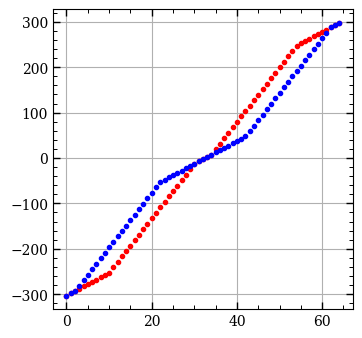

In [7]:
zz = np.array([-302.94294643, -297.935625  , -292.92830357, -287.92098214,
       -282.91366071, -277.90633929, -272.89901786, -267.89169643,
       -262.884375  , -257.87705357, -252.86973214, -240.85216071,
       -228.83458929, -216.81701786, -204.79944643, -192.781875  ,
       -180.76430357, -168.74673214, -156.72916071, -144.71158929,
       -132.69401786, -120.67644643, -108.658875  ,  -96.64130357,
        -84.62373214,  -72.60616071,  -60.58858929,  -48.57101786,
        -36.55344643,  -24.535875  ,  -12.51830357,   -7.51098214,
         -2.50366071,    2.50366071,    7.51098214,   19.52855357,
         31.546125  ,   43.56369643,   55.58126786,   67.59883929,
         79.61641071,   91.63398214,  103.65155357,  115.669125  ,
        127.68669643,  139.70426786,  151.72183929,  163.73941071,
        175.75698214,  187.77455357,  199.792125  ,  211.80969643,
        223.82726786,  235.84483929,  247.86241071,  252.86973214,
        257.87705357,  262.884375  ,  267.89169643,  272.89901786,
        277.90633929,  282.91366071,  287.92098214,  292.92830357,
        297.935625  ])
z1 = np.array([-302.94294643, -297.935625  , -292.92830357, -280.91073214,
       -268.89316071, -256.87558929, -244.85801786, -232.84044643,
       -220.822875  , -208.80530357, -196.78773214, -184.77016071,
       -172.75258929, -160.73501786, -148.71744643, -136.699875  ,
       -124.68230357, -112.66473214, -100.64716071,  -88.62958929,
        -76.61201786,  -64.59444643,  -52.576875  ,  -47.56955357,
        -42.56223214,  -37.55491071,  -32.54758929,  -27.54026786,
        -22.53294643,  -17.525625  ,  -12.51830357,   -7.51098214,
         -2.50366071,    2.50366071,    7.51098214,   12.51830357,
         17.525625  ,   22.53294643,   27.54026786,   32.54758929,
         37.55491071,   42.56223214,   47.56955357,   59.587125  ,
         71.60469643,   83.62226786,   95.63983929,  107.65741071,
        119.67498214,  131.69255357,  143.710125  ,  155.72769643,
        167.74526786,  179.76283929,  191.78041071,  203.79798214,
        215.81555357,  227.833125  ,  239.85069643,  251.86826786,
        263.88583929,  275.90341071,  287.92098214,  292.92830357,
        297.935625  ])
plt.plot(zz, '.')
plt.plot(z1, '.')
plt.grid()

In [3]:
dt = 10e-12
dz = g_c*dt; print 'Light travelled: ', dz*1e3
EG = 30*dz
gg = kinetic2gamma(EG); print 'Gamma: ', gg
bb = gamma2beta(gg); print 'Beta: ', bb/2
dz = bb*g_c*dt
print 'Excursion: ', dz*1e3

Light travelled:  2.99792458
Gamma:  1.17600376299
Beta:  0.26311892769329304
Excursion:  1.577621401589932


## Radial space charge calculated by analytical formula

In [143]:
rho_z = lambda z, sigma_z: 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-z**2/2./sigma_z**2)
rho_r = lambda r, sigma_r: 1./(2.*np.pi)/sigma_r**2*np.exp(-r**2/2./sigma_r**2)

fEr = lambda r, z, sigma_r, sigma_z, gamma, Qtot:\
       Qtot*rho_z(z*gamma, sigma_z*gamma)/(2.*np.pi*r*g_eps0)*(1.-np.exp(-r**2/2./sigma_r**2))*gamma

Text(0,0.5,'$E_r(z)$ (V/m)')

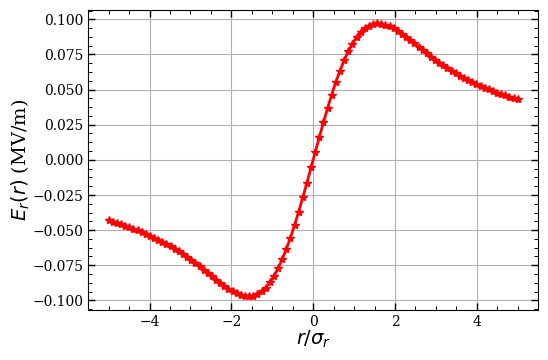

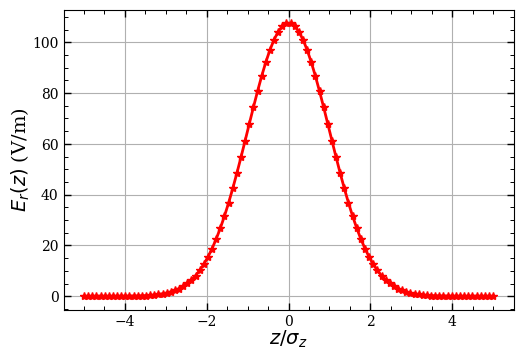

In [145]:
Qtot = 30e-12; sigma_r = 1.0e-3; sigma_z = 1.0e-3
gamma = 1. #+16./g_mec2

rr = np.linspace(-5*sigma_r, 5*sigma_r, 100)
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)/gamma**2
zz = np.linspace(-5*sigma_z, 5*sigma_z, 100)
Er_z = fEr(1e-6, zz, sigma_r, sigma_z, gamma, Qtot)/gamma**2

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rr/sigma_r, Er_r/1e6, '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Er_z, '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_r(z)$ (V/m)')

## Space charge in 3D coordinate system

In [5]:
from tracking import *

In [ ]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = 1.0*sigma_y
print sc.fEy(0, 10e-6, 0), sc.fEy1(0, 10e-6, 0)
#print sc.fEx(v, 0, 0)

## Space charge in $R-Z$ coordinate system

In [80]:
from tracking import *

In [81]:
Qtot = 30e-12; sigma_r = 1e-3; sigma_z = 1e-3; gamma = 1. #+150./g_mec2; print gamma
nr = 16; nz = 16; dr = 5*sigma_r/nr; dz = 5*sigma_z/nz

import timeit
#sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
scrz = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
# time1 = timeit.default_timer()
scrz.build()
# time2 = timeit.default_timer()
# print time2-time1

# rr = np.arange(0, 5*sigma_r, dr)+dr/2.
# zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.
r0, z0 = dr/2., dz/2.
print r0, z0

time1 = timeit.default_timer()
phi = scrz.phi_static_RZ(r0*7, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

time1 = timeit.default_timer()
phi = scrz.phi_static(r0, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

# time1 = timeit.default_timer()
# phi = scrz.phi_static_RZ(r0, z0)
# time2 = timeit.default_timer()
# print time2-time1, ': ', phi

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
0.00015625 0.00015625
0.0290394000003 :  187.15750604015918
853.668245178953
0.00977369999964 :  214.36798609137747


[ 12263.20901055  13168.33553977  15191.03941735  17702.88606817
  20846.40475884  24781.10182317  29641.28713733  35444.66811064
  41944.04050869  48451.04982269  53718.92476587  56016.73809357
  53503.24327218  44874.77948676  30059.87075943  10596.85618021
 -10596.85618021 -30059.87075943 -44874.77948677 -53503.24327218
 -56016.73809357 -53718.92476587 -48451.04982269 -41944.04050869
 -35444.66811064 -29641.28713733 -24781.10182317 -20846.40475884
 -17702.88606817 -15191.03941735 -13168.33553977 -12263.20901055]


Text(0,0.5,'$E_z(z)$ (MV/m)')

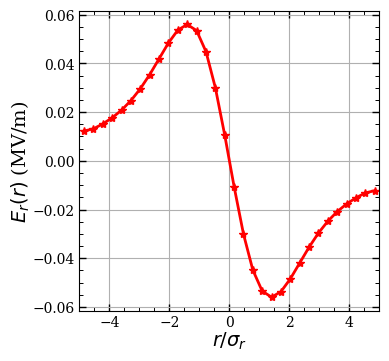

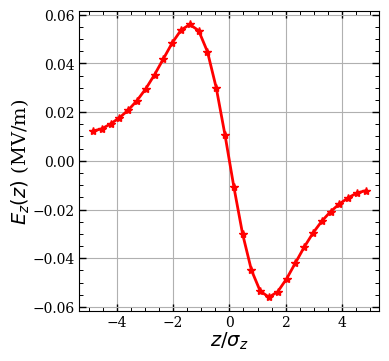

In [82]:
rr = np.arange(-5*sigma_r, 5*sigma_r, dr)+dr/2.
zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.

R, Z = np.meshgrid(rr, zz)
Er = np.array([scrz.EM3D(r, 0, 0)[0]-scrz.EM3D(r, 0, 0)[4] for r in rr]); print Er
Ez = np.array([scrz.EM3D(0, 0, z)[2] for z in zz])
#np.savetxt('static_RZ_64x16.dat', np.array([rr, Er]).T, fmt='%12.4E')

def fEr(r, sigma_r, Qtot):
    if abs(r) < sigma_r:
        return Qtot/4./np.pi/g_eps0*r/sigma_r**3
    else:
        return Qtot/4./np.pi/g_eps0*r/r**2/abs(r)
#Er_0 = np.array([-fEr(rp, sigma_r, Qtot) for rp in rr])

fig, ax = plt.subplots()
ax.plot(rr/sigma_r, Er/1e6, '-*')
ax.set_xlim(-5, 5)
#ax.set_ylim(0, 100000)
#ax.plot(rr*1e6, Er_0, '-*')
phi = np.array([scrz.phi_2d(r, 0)[0] for r in rr])
#ax.plot(rr*1e3, phi*1e5, '-*')
#ax.plot(rr*1e6, np.gradient(phi, 5.*sigma_r/nr), '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots()
ax.plot(zz/sigma_z, Ez/1e6, '-*')
phi = np.array([scrz.phi_2d(0, z)[0] for z in zz])
#ax.plot(zz*1e3, phi*1e5, '-')
#ax.plot(zz*1e6, np.gradient(phi, 5.*sigma_z/nz), '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z(z)$ (MV/m)')

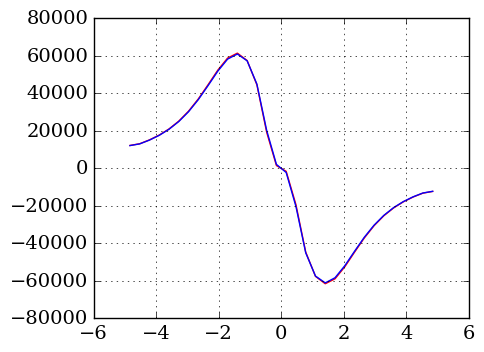

In [121]:
data = np.loadtxt('static_RZ.dat')
#plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ3.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ4.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
plt.grid()
#plt.xlim(0,5)
plt.show()

In [3]:
### generate 3D distribution
sigma_r = 1.0e-6; sigma_z = 1.0e-6; nr = 32; nz = 64

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]
x, y, z = np.random.multivariate_normal(mean, cov, 100000).T

dr = 5*sigma_r/nr; dz = 5*sigma_z/nz
rr = np.linspace(0, 5*sigma_r, nr)
zz = np.linspace(-5*sigma_r, 5*sigma_r, 2*nz+1)

global rho;
rho = np.zeros((nr, nz*2+1))

for i in np.arange(len(x)):
    ir = int(np.sqrt(x[i]**2+y[i]**2)/dr+0.)
    if z[i]>=0:
        iz = nz+int(z[i]/dz+0.5)
    else:
        iz = nz-int(-z[i]/dz+0.5)
    if ir>=0 and ir<nr and iz>=0 and iz < nz*2+1:
        rho[ir, iz] += 1.
#print rho.sum(axis=0)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(z*1e6, y*1e6, '.')
ax.grid()
ax.axis([-4, 4, -4, 4])

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(rr*1e6, rho.sum(axis=1), '-*'); ax.hist(np.sqrt(x**2+y**2)*1e6, bins=32)
#ax.plot(zz*1e6, rho[3,:], '-*'); #ax.hist(z*1e6, bins=32)
ax.grid()

In [54]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]

xb, yb, zb = np.random.multivariate_normal(mean, cov, 100000).T

### Comparison

The 3D method gives accurate solutions to the space charge forces, while the RZ method is only valid when gamma is small. The reason lies that when gamma is very large, the discrete charge rings are far from the point concerned and the coulomb force is under estimated, due to the inverse square law. The radial component can be easily calculated using the analytical formula, which is only valid for relativistic beam with a large aspect ratio.

In [55]:
nr = 40; nz = 200; gamma = 10.#+150./g_mec2; print gamma

sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
sc2d = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
sc.get_rho_RZ(xb, yb, zb)

#rp, zp = sc.dr*(8+0.5), sc.dz*(20+0.5) ; print rp, zp
rp, zp = 1.0625e-6, 1.0625e-6
print sc3d.fEx(rp, 0, zp)/1e9, sc3d.fEz(rp, 0, zp)/1e9
print sc.fEr(rp, zp, 0)/1e9, sc.fEz(rp, zp, 0)/1e9
print sc.fEr(rp, zp, 1)/1e9, sc.fEz(rp, zp, 1)/1e9
print fEr(rp, zp, sigma_r, sigma_z, gamma, Qtot)/1e9

1.64781491978 0.0865035955797
[ 1.63097047] [ 0.09146845]
1.65547358533


### Calculation of space charge using 3D

In [106]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = -1.0*np.array([3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_y
Ey_y = np.array([])
Ey_y = np.zeros(len(yy))
for i, v in enumerate(yy):
    Ey_y[i] = sc.fEy(0, v, 0)
    print Ey_y[i],',',

KeyboardInterrupt: 

In [87]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2

sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_z
Ez_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    Ez_z[i] = sc.fEz(0, 0, v)
    print Ez_z[i],',', 

In [71]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-1068.71155235, -1329.53950284, -1701.24698937, -2259.18565239, -3159.65480883, -3839.9478985,\
                 -6258.93259551, -8938.47979824, -15170.6328943, -31536.0527241, -70891.8916114, -144539.35086,\
                 -235874.717597, -269004.384616, -278927.714006, -256341.826416, -197732.48045, -107937.469484, 0])

In [36]:
Qtot = 50e-12; sigma_r = 0.6e-6; sigma_z = 1.0e-6; gamma = 150./g_mec2+1; 
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-53435.5903638, -66476.9950999, -85062.3827171, -112959.342919, -157982.864754, -191997.588353,\
                 -313328.084992, -449759.290142, -774702.576927, -1647178.35564, -3776520.26685, -7798420.90377,\
                 -12821018.2989, -14658361.6471, -15227062.9301, -14012182.3256, -10818082.5589, -5908374.12811, 0])

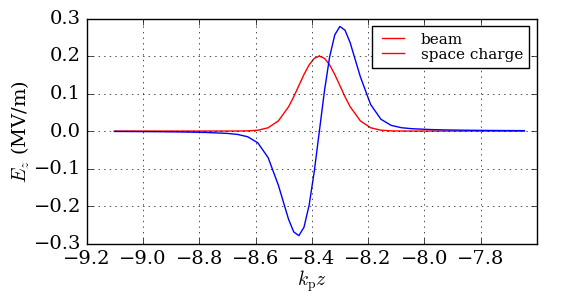

In [78]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp
beam_zc = -4-60e-6*kp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( zz*kp+beam_zc, gaussian( zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot(-zz*kp+beam_zc, gaussian(-zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot( zz*kp+beam_zc,  Ez_z/1e6, 'b-')
ax.plot(-zz*kp+beam_zc, -Ez_z/1e6, 'b-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}z$')
ax.set_ylabel(r'$E_z$ (MV/m)')
ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [86]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_r
# Ex_x = np.array(-59707075934.7, -66350871987.8, -74654763320.6, -85330177721.7, -99562821590.1, -108619429210.0,\
#                 -132764203145.0, -149321525576.0, -170343103058.0, -196962902383.0, -228515206451.0, -258341977376.0,\
#                 -161415282712.0, -155502256288.0, -141063532600.0, -117193111286.0, -84256877214.5, -44123794492.0)
Ex_x = np.zeros(len(xx))
for i, v in enumerate(xx):
    Ex_x[i] = sc.fEx(v, 0, 0)
    print Ex_x[i],',',

In [89]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_r
Ex_x = np.array([-715601723.284, -795391164.78, -895104740.916, -1023279988.76, -1194145916.5, -1302863999.23,\
                 -1592682854.87, -1791413837.0, -2043717741.79, -2363202504.24, -2741879971.6, -3099854264.60,\
                 -3228305654.24, -3110045125.8, -2821321192.07, -2343859039.70, -1685042467.6, -882358273.419, 0])

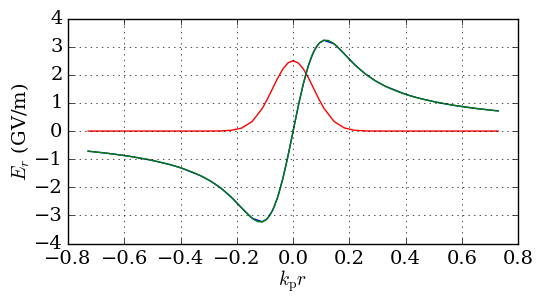

In [97]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( xx*kp, gaussian( xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot(-xx*kp, gaussian(-xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot( xx*kp,  Ex_x/1e9, 'b-')
ax.plot(-xx*kp, -Ex_x/1e9, 'b-')
rr = np.linspace(-10, 10, 100)*sigma_r
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)
ax.plot(rr*kp, Er_r/1e9, 'g-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}r$')
ax.set_ylabel(r'$E_r$ (GV/m)')
#ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [27]:
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ex_z = np.array([62057.3771687, 86475.3616713, 125951.804807, 194666.540523, 327772.661093, 446178.515856,\
                2299467.77799, 12623656.7501, 74092275.857, 364422133.978, 1421697980.49, 4345913764.51,\
                10375473897.8, 14606829181.1, 19325039251.5, 24026155099.5, 28069625683.3, 30815593716.5,\
                31789393945.8])
np.savetxt('beam-loading/space-charge.dat', np.array([zz, Ez_z, Ex_z]).T, fmt = '%12.6E')
#xx = np.linspace(-10*sigma_r, 10*sigma_r, 20)
#Ex_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    #Ex_z[i] = SC_Ex(45e-6/4., 0, v, sigma_r, sigma_z, gamma)
    print Ex_z[i], 

62057.3771687 86475.3616713 125951.804807 194666.540523 327772.661093 446178.515856 2299467.77799 12623656.7501 74092275.857 364422133.978 1421697980.49 4345913764.51 10375473897.8 14606829181.1 19325039251.5 24026155099.5 28069625683.3 30815593716.5 31789393945.8


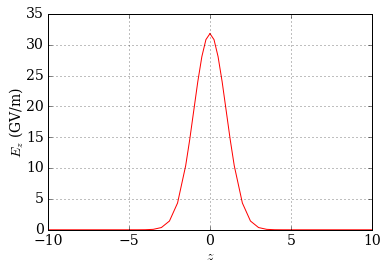

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Ex_z/1e9, '-')
ax.plot(-zz/sigma_z, Ex_z/1e9, 'r-')
ax.grid()
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$E_x$ (GV/m)')

# Space charge 3D using FFT
## Step-by-step scripts

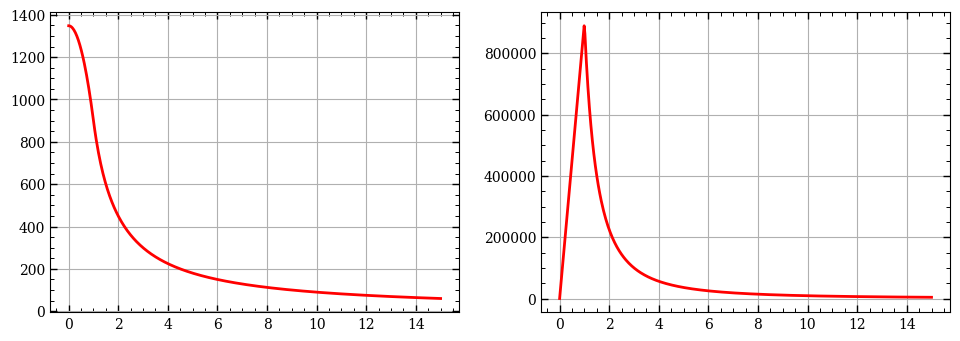

In [21]:
def static_potential(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        phi = cc*((R**2-r**2)/2./R**3+1./R)
    else:
        phi = cc/r
    return phi
def electric_field(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        Er = cc*r/R**3
    else:
        Er = cc/r**2
    return Er

R = 1e-3
r = np.linspace(0, 15*R, 501)
phi = np.array([static_potential(x, R) for x in r])
Er = np.array([electric_field(x, R) for x in r])

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot(r/R, phi, '-')
ax1.grid()
ax2.plot(r/R, Er, '-')
ax2.grid()

np.savetxt('R1mm.dat', np.array([r, phi, Er]).T, fmt = '%12.6E')

In [947]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c

def integral_IGF3D(xp, yp, zp, hx, hy, hz):
    '''
    Integral of green function in 3D cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    Returns
      rr: integral over a volume defined by (xp, yp, zp, hx, hy, hz)
    '''
    xl, xu, yl, yu, zl, zu = xp-hx/2., xp+hx/2., yp-hy/2., yp+hy/2., zp-hz/2., zp+hz/2.
    rr = (IGF3D((xu, yu, zu))-IGF3D((xu,yl,zu))-IGF3D((xl,yu,zu))+IGF3D((xl,yl,zu)))-\
         (IGF3D((xu, yu, zl))-IGF3D((xu,yl,zl))-IGF3D((xl,yu,zl))+IGF3D((xl,yl,zl)))
    return rr
def transposed_IGF3D(x, y, z, xp, yp, zp, hx, hy, hz):
    '''
    Transposed finite integral of green function in 3D Cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    '''
    xl, xu, yl, yu, zl, zu = x-xp+hx/2., x-xp-hx/2., y-yp+hy/2., y-yp-hy/2., z-zp+hz/2., z-zp-hz/2.
    rr = (IGF3D(xu, yu, zu)-IGF3D(xu,yl,zu)-IGF3D(xl,yu,zu)+IGF3D(xl,yl,zu))-\
         (IGF3D(xu, yu, zl)-IGF3D(xu,yl,zl)-IGF3D(xl,yu,zl)+IGF3D(xl,yl,zl))
    return -rr

In [948]:
Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz, Nc = 32, 32, 32, 1.5
hx, hy, hz = sigma_x*2*Nc/Nx, sigma_y*2*Nc/Ny, sigma_z*2*Nc/Nz; print hx
xc, yc, zc = Nc*sigma_x, Nc*sigma_y, Nc*sigma_z
xf = 5*sigma_x; yf = 0*sigma_y; zf = 0*sigma_z; # distance from field domain center to charge domain center
xleft = Nc*sigma_x

def density0((x, y, z)):
    '''
    3D Gaussian distribution
    '''
    f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x-xc)**2/2./sigma_x**2)
    f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y-yc)**2/2./sigma_y**2)
    f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-zc)**2/2./sigma_z**2)
    return f_x*f_y*f_z
def density((x, y, z)):
    '''
    3D uniform distribution in a sphere
    '''
    r = np.sqrt((x-xc)**2+(y-yc)**2+(z-zc)**2)
    rho = np.where(r>sigma_x, 0, 3./(4*np.pi*sigma_x**3))
    return rho

def cyclic_IGF3D((i, j, k)):
    '''
    Cyclic integrated GF
    '''
    xi = np.where(i<Nx, xf+i*hx, xf-(2*Nx-i)*hx)
    yj = np.where(j<Ny, yf+j*hy, yf-(2*Ny-j)*hy)
    zk = np.where(k<Nz, zf+k*hz, zf-(2*Nz-k)*hz)
    
    GF = integral_IGF3D(xi, yj, zk, hx, hy, hz)
    #GF = GF3D(xi, yj, zk)
    return GF
def cyclic_density((i, j, k)):
    '''
    Cyclic charge density
    '''
    xi, yj, zk = i*hx, j*hy, k*hz
    rho = np.where(i.any()>Nx or j.any()>Ny or k.any()>Nz, 0, density((xi, yj, zk)))
    return rho
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

9.375e-05


In [949]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs without using the mapping, slow
GFC = cyclic_IGF3D2(II)

time3 = timeit.default_timer()

print time2-time1
print time3-time2

0.0169945000089
0.416821499995


In [950]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs by using the mapping, faster
xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
zz = zf-Nz*hz+np.arange(2*Nz+1)*hz-0.5*hz
XX = np.meshgrid(xx, yy, zz, indexing = 'ij')
IGF_MAP = IGF3D(XX)

time3 = timeit.default_timer()

ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

time4 = timeit.default_timer()

print time2-time1
print time3-time2
print time4-time3
print time4-time2

0.0161569999764
0.056957599998
0.0475659000222
0.10452350002


In [951]:
GFC_FFT = fftn(GFC)
RHOC_FFT = fftn(RHOC)
PHIC_FFT = GFC_FFT*RHOC_FFT

PHIC = ifftn(PHIC_FFT)
PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]

Text(0.5,1,'static potential')

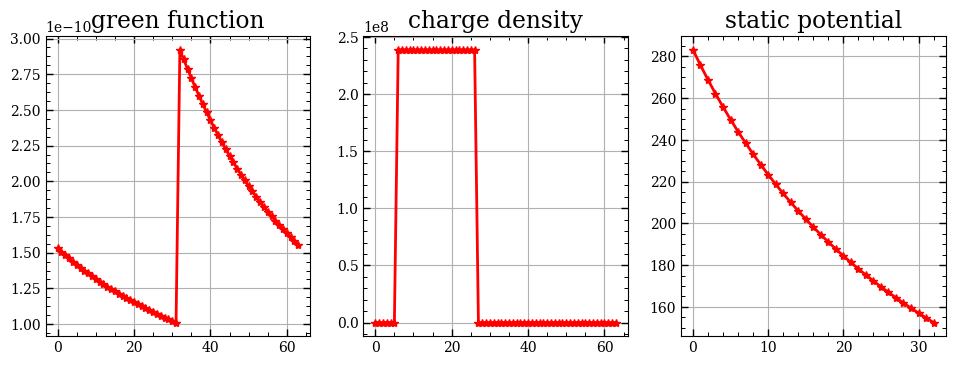

In [952]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
ax1.grid()
ax1.set_title(r'green function')
ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
ax2.grid()
ax2.set_title(r'charge density')
ax3.plot(PHI[:, Ny/2-1, Nz/2-1], '-*')
ax3.grid()
ax3.set_title(r'static potential')

In [953]:
Ex, Ey, Ez = np.gradient(PHI, hx, hy, hz)

(0, 500)

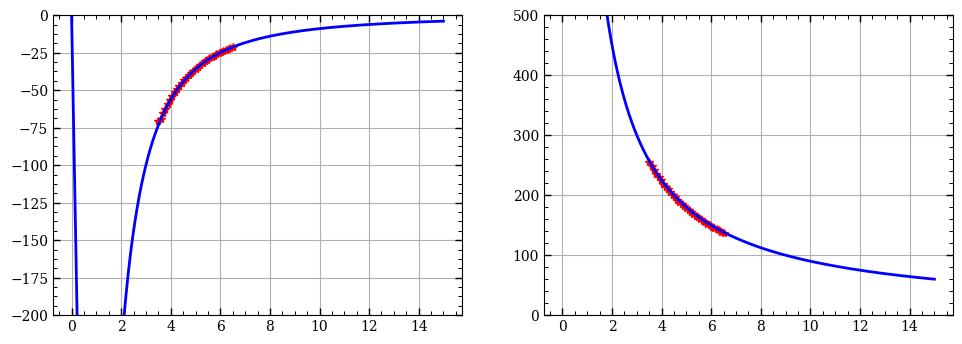

In [954]:
rr = np.linspace(-Nc*sigma_x, Nc*sigma_x, Nx+1)+hx/2.+xf

data = np.loadtxt('R1mm.dat')

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot((rr-hx/2)/sigma_x, Ex[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0/1e3, '-*')
ax1.plot(data[:,0]/sigma_x, -data[:,2]/1e3, '-')
ax1.set_ylim(-200, 0)
ax1.grid()

ax2.plot((rr-hx/2)/sigma_x, PHI[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0, '-*')
ax2.plot(data[:,0]/sigma_x, data[:,1], '-')
ax2.grid()
ax2.set_ylim(0, 500)

## Class-level scripts

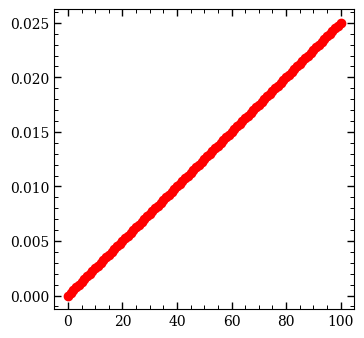

In [160]:
beta = np.linspace(0, 0.025, 101)
gamma = beta2gamma(beta)
bg = beta*gamma

#plt.plot(gamma)
plt.plot(bg)

In [4]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c
def shifted_IGF3D(x, y, z, xc = 0, yc = 0, zc = 0):
    return IGF3D(x+xc, y+yc, z+zc)
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

from scipy.interpolate import RegularGridInterpolator, Rbf
from numpy.fft import fftn, ifftn
import inspect

class SpaceCharge3DFFT():
    def __init__(self, nx = 32, ny = 32, nz = 32, N_cutoff = 5, debug = 0,\
                 Lspch = True, Lmirror = False, Lbin = False, Nbin = 1):
        
        self.nx = nx; self.ny = ny; self.nz = nz
        self.N_cutoff = N_cutoff       
        self.debug = debug
        
        self.Lspch = Lspch; self.Lmirror = Lmirror
        self.Lbin = Lbin; self.Nbin = Nbin
        
        return
    def get_rho_3D0(self, sigma_x = 1e-3, sigma_y = 1e-3, sigma_z = 1e-3, gamma0 = 1, Qtot = 100e-12):
        '''
        Set charge density to 3D gaussian distributions
        '''
        self.Qtot = Qtot
        self.gamma0 = gamma0
        
        sigma_z_static = sigma_z*gamma0
         
        Nx, Ny, Nz = self.nx, self.ny, self.nz
        N_cutoff = self.N_cutoff
        
        self.gamma0 = gamma0
        
        def rho_3D((x_static, y_static, z_static)):
            xc, yc, zc = 0, 0, 0
            f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x_static-xc)**2/2./sigma_x**2)
            f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y_static-yc)**2/2./sigma_y**2)
            f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z_static-zc)**2/2./sigma_z_static**2)
            
            return f_x*f_y*f_z
        
        xgrid = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
        ygrid = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
        zgrid_static = np.linspace(-N_cutoff*sigma_z_static, N_cutoff*sigma_z_static, Nz+1)
        
        XX = np.meshgrid(xgrid, ygrid, zgrid_static, indexing = 'ij')        
        rho = rho_3D(XX)
        
        self.dx = N_cutoff*2*sigma_x/Nx
        self.dy = N_cutoff*2*sigma_y/Ny
        self.dz = N_cutoff*2*sigma_z/Nz
        self.dz_static = self.dz*gamma0
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.sigma_z = sigma_z
        self.sigma_z_static = self.sigma_z*gamma0
        
        self.xgrid = xgrid; self.ygrid = ygrid; self.zgrid_static = zgrid_static
        self.zmean = 0; self.zref = 0
        self.rho = rho
        return
    def get_rho_3D1(self, R = 1e-3, gamma0 = 1, Qtot = 100e-12):
        '''
        Set charge density to 3D uniform distributions confined in a sphere
        '''
        self.Qtot = Qtot
        self.gamma0 = gamma0
        
        sigma_x = R; sigma_y = R; sigma_z = R
        sigma_z_static = sigma_z*gamma0
        
        Nx, Ny, Nz = self.nx, self.ny, self.nz
        N_cutoff = self.N_cutoff  
        
        def rho_3D((x_static, y_static, z_static)):
            radius = R #*np.sqrt(15)/5.0;
            xc, yc, zc = 0, 0, 0
            r = np.sqrt((x_static-xc)**2+(y_static-yc)**2+(z_static/gamma0-zc)**2)
            rho = np.where(r>radius, 0, 3./(4*np.pi*radius**3))
            return rho
        
        xgrid = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
        ygrid = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
        zgrid_static = np.linspace(-N_cutoff*sigma_z_static, N_cutoff*sigma_z_static, Nz+1)
        
        XX = np.meshgrid(xgrid, ygrid, zgrid_static, indexing = 'ij')        
        rho = rho_3D(XX)
        
        self.dx = N_cutoff*2*sigma_x/Nx
        self.dy = N_cutoff*2*sigma_y/Ny
        self.dz = N_cutoff*2*sigma_z/Nz
        self.dz_static = self.dz*gamma0
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.sigma_z = sigma_z
        self.sigma_z_static = self.sigma_z*gamma0
        
        self.xgrid = xgrid; self.ygrid = ygrid; self.zgrid_static = zgrid_static
        self.zgrid = zgrid_static/gamma0
        
        self.zmean = 0; self.zref = 1.5*R
        self.rho = rho*Qtot
        return
    
    def get_rho_3D(self, dist, nx = None, ny = None, nz = None, N_cutoff = None,\
                   format = 'Astra', Lemit = True):
        '''
        Parameters
          dist: particle distributions in the same format as Astra, but absolute `z` and `Pz*c`
        '''
        if nx is not None:
            self.nx = nx
        if ny is not None:
            self.ny = ny
        if nz is not None:
            self.nz = nz
        Nx = self.nx; Ny = self.ny; Nz = self.nz
        if N_cutoff is not None:
            self.N_cutoff = N_cutoff
        N_cutoff = self.N_cutoff
        
        if format == 'Astra' or format == 'ASTRA' or format == 'astra':
            ix, iy, iz, iux, iuy, iuz, iw = 0, 1, 2, 3, 4, 5, 7
            
            #self.zref = 0 #dist[0,iz]
            #dist[0,iz] = 0
            
            # Select active partiles
            select = (dist[:,9]>0); dist = dist[select]
            x = dist[:,ix]
            y = dist[:,iy]
            z = dist[:,iz]
            w = dist[:,iw]*1e-9; self.Qtot = np.sum(w)
            
            self.zmean =  weighted_mean(z, w)
            self.zmean = (np.max(z)+np.min(z))*0.5
            z -= self.zmean
                        
            bgx, bgy, bgz = dist[:,iux]/g_mec2/1e6, dist[:,iuy]/g_mec2/1e6, dist[:,iuz]/g_mec2/1e6
            
            gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)
            gamma0 = weighted_mean(gamma, w)
            z_static = z*gamma0

        self.gamma0 = gamma0;              #print inspect.stack()[0][3], 'gamma = ', self.gamma0
        self.sigma_x = weighted_std(x, w); #print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
        self.sigma_y = weighted_std(y, w); #print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
        self.sigma_z_static = weighted_std(z_static, w); #print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
        self.sigma_z = self.sigma_z_static/gamma0;       #print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
        
        xmin = np.max([np.min(x), -N_cutoff*self.sigma_x])
        xmax = np.min([np.max(x),  N_cutoff*self.sigma_x])
        ymin = np.max([np.min(y), -N_cutoff*self.sigma_y])
        ymax = np.min([np.max(y),  N_cutoff*self.sigma_y])
        zmin_static = np.max([np.min(z_static), -N_cutoff*self.sigma_z_static])
        zmax_static = np.min([np.max(z_static),  N_cutoff*self.sigma_z_static])
        zmin, zmax = zmin_static/gamma0, zmax_static/gamma0
        
        zmin, zmax = np.min(z), np.max(z)
        if Lemit:
            zmin = -self.zmean
        
        nx0 = 1 # Guarding grids on one side
        ny0 = 1
        nz0 = 1
        
        if Lemit:
            nz0 = 2
        
        hx = (xmax-xmin)/(Nx-2*nx0); hy = (ymax-ymin)/(Ny-2*ny0)
        hz = (zmax-zmin)/(Nz-2*nz0)
        
        zmin_static, zmax_static = zmin*gamma0, zmax*gamma0
        hz_static = hz*gamma0
        
        self.dx = hx; self.dy = hy; self.dz = hz; #print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        self.dz_static = hz_static
        
        if self.debug and 0:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            print inspect.stack()[0][3], 'gamma = ', self.gamma0
            print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
            print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
            print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
            print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
            print inspect.stack()[0][3], 'mesh sizes in rest frame: ', hx, hy, hz_static
        
        xgrid = np.linspace(xmin-nx0*hx, xmax+nx0*hx, Nx+1)
        ygrid = np.linspace(ymin-ny0*hy, ymax+ny0*hy, Ny+1)
        zgrid = np.linspace(zmin-nz0*hz, zmax+nz0*hz, Nz+1)
        
        zgrid_static = zgrid*gamma0
        
        ranges = [(xgrid[0]-0.5*hx, xgrid[-1]+0.5*hx), (ygrid[0]-0.5*hy, ygrid[-1]+0.5*hy),\
                  (zgrid_static[0]-0.5*hz_static, zgrid_static[-1]+0.5*hz_static)]
        rho, edges = np.histogramdd((x, y, z_static), bins = (Nx+1, Ny+1, Nz+1),\
                                    range = ranges, weights = w)
        
        if self.debug:
            #print xgrid/self.sigma_x, ygrid/self.sigma_y, zgrid/self.sigma_z_static
            #print rho
            #print ranges
            fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (8, 4))
            data = np.abs(rho[:,Ny/2-1, Nz/2-1])
            ax1.plot(xgrid*1e3, data/np.max(data), '-*')
            ax1.grid()
            ax1.set_xlabel(r'$x$ (mm)')
            ax1.set_ylabel(r'$\rho$ (arb. unit)')
            
            [aX,aY] = np.meshgrid(xgrid, ygrid)
            data = np.abs(rho[:,:,Nz/2-1])
            v = np.linspace(0.05, 1., 96)
            ax2.contourf(aX*1e3, aY*1e3, data/np.max(data), v, linestyles = None)
            ax2.grid()
            ax2.set_xlabel(r'$x$ (mm)')
            ax2.set_ylabel(r'$y$ (mm)')
            
            fig.savefig('charge-density.eps')
        
        #rho = sgolay2d(rho, window_size=11, order=4)   
        #self.rho_RZ = interp2d(rr, zz, rho.T, kind = 'cubic')
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.zgrid = zgrid
        self.zgrid_static = zgrid_static
        self.rho = rho/(hx*hy*hz_static)
        return  
    def build(self, Xshift = (0, 0, 0), N_cutoff = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; 
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z_static = self.sigma_z_static
        #hx = self.dx; hy = self.dy; hz = self.dz_static
        
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        if self.Lspch:
            # Create arrays for GFs and densities
            GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
            RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

            xgrid = self.xgrid
            ygrid = self.ygrid
            zgrid_static = self.zgrid_static
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho

            hx = xgrid[1]-xgrid[0]; hy = ygrid[1]-ygrid[0]; hz_static = zgrid_static[1]-zgrid_static[0]
            if self.debug:
                print inspect.stack()[0][3], Nx, Ny, Nz
                print inspect.stack()[0][3], hx, hy, hz_static

            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xf, yf, zf = Xshift
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_MAP = IGF3D(XX)

            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_FFT = fftn(GFC)
            RHOC_FFT = fftn(RHOC)
            PHIC_FFT = GFC_FFT*RHOC_FFT

            PHIC = ifftn(PHIC_FFT)
            self.PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
            
        if self.Lspch and self.Lmirror:
            #zf = (self.zref+self.zmean)*2; print zf
            zf = (0+self.zmean)*2; print zf
            
            GFC_mirror = np.zeros((2*Nx, 2*Ny, 2*Nz))
            RHOC_mirror = np.zeros((2*Nx, 2*Ny, 2*Nz))
            
            RHOC_mirror[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho[:,:,::-1]
            #RHOC_mirror = RHOC[:,:,::-1]
            #zgrid = -self.zgrid[::-1]
            
            if self.debug:
                print inspect.stack()[0][3], Nx, Ny, Nz
                print inspect.stack()[0][3], hx, hy, hz_static
            
            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_mirror_MAP = IGF3D(XX)
            
            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC_mirror = cyclic_IGF3D_mapping(II, IGF_mirror_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_mirror_FFT = fftn(GFC_mirror)
            RHOC_mirror_FFT = fftn(RHOC_mirror)
            PHIC_mirror_FFT = GFC_mirror_FFT*RHOC_mirror_FFT

            PHIC_mirror = ifftn(PHIC_mirror_FFT)
            self.PHI_mirror = PHIC_mirror[:Nx+1,:Ny+1,:Nz+1]
        
        if self.debug and self.Lmirror:
            
            Ex_static, Ey_static, Ez_static = np.gradient(self.PHI, hx, hy, hz_static) 
            Ex_static_m, Ey_static_m, Ez_static_m = np.gradient(self.PHI_mirror, hx, hy, hz_static) 
            cc = -1./4/np.pi/g_eps0
        
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex_static[:, Ny/2-1, Nz/4-1]*cc/1e3, '-*')
            ax1.plot(xgrid/sigma_x, -Ex_static_m[:, Ny/2-1, Nz/4-1]*cc/1e3, '-o')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            
            ax2.plot(zgrid_static/sigma_z_static, Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.plot(zgrid_static/sigma_z_static, -Ez_static_m[Nx/2-1, Ny/2-1, :]*cc/1e3, '-o')
            #print Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3
            #print -Ez_static_m[Nx/2-1, Ny/2-1, :]*cc/1e3
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[Nx/2-1, Ny/2-1, :], '-*')
            ax1.plot(GFC_mirror[Nx/2-1, Ny/2-1, :], '-o')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[Nx/2-1, Ny/2-1, :], '-*')
            ax2.plot(RHOC_mirror[Nx/2-1, Ny/2-1, :], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[Nx/2-1, Ny/2-1, :], '-*')
            ax3.plot(self.PHI_mirror[Nx/2-1, Ny/2-1, :], '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        if self.Lspch and self.Lmirror:
            self.PHI -= self.PHI_mirror
        
        Ex_static, Ey_static, Ez_static = np.gradient(self.PHI, hx, hy, hz_static)     
        cc = -1./4/np.pi/g_eps0
        
        if self.debug:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex_static[:, Ny/2-1, Nz/4-1]*cc/1e3, '-*')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            ax2.plot(zgrid_static/sigma_z_static, Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[Nx/2-1, Ny/2-1, :], '-*')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[Nx/2-1, Ny/2-1, :], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[Nx/2-1, Ny/2-1, :]*cc*(-1), '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        fEx3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ex_static, bounds_error = False, fill_value = None)
        fEy3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ey_static, bounds_error = False, fill_value = None)
        fEz3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ez_static, bounds_error = False, fill_value = None)
        
        gamma0 = self.gamma0; beta = gamma2beta(gamma0); zmean = self.zmean
        def EM3D(x, y, z, t = 0):
            if np.isscalar(x):
                x = [x]
                y = [y]
                z = [z]
            x = np.asarray(x)
            y = np.asarray(y)
            z = np.asarray(z)
            if not np.isscalar(t):
                t = np.asarray(t)

            z_static = (z-zmean)*gamma0
            Ex_static = fEx3D_static((x, y, z_static))*cc
            Ey_static = fEy3D_static((x, y, z_static))*cc
            Ez_static = fEz3D_static((x, y, z_static))*cc
            
            # return normalied E and B in lab frame
            F2d = np.zeros((len(x), 6))
            F2d[:,0] = gamma0*Ex_static
            F2d[:,1] = gamma0*Ey_static
            F2d[:,2] = Ez_static
            F2d[:,3] = beta*gamma0*Ey_static/g_c
            F2d[:,4] =-beta*gamma0*Ex_static/g_c
            
            return F2d
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]
        
        self.EM3D = EM3D
        return
    
    def get_rho_3D_binned(self, dist, nx = None, ny = None, nz = None, N_cutoff = None,\
                          nbins = 4, format = 'Astra', Lemit = True):
        '''
        Parameters
          dist: particle distributions in the same format as Astra, but absolute `z` and `Pz*c`
        '''
        if nx is not None:
            self.nx = nx
        if ny is not None:
            self.ny = ny
        if nz is not None:
            self.nz = nz
        Nx = self.nx; Ny = self.ny; Nz = self.nz
        if N_cutoff is not None:
            self.N_cutoff = N_cutoff
        N_cutoff = self.N_cutoff
        
        if format == 'Astra' or format == 'ASTRA' or format == 'astra':
            ix, iy, iz, iux, iuy, iuz, iw = 0, 1, 2, 3, 4, 5, 7
            
            self.zref = dist[0,iz]
            
            # Select active partiles
            select = (dist[:,9]>0); dist = dist[select]
            x = dist[:,ix]
            y = dist[:,iy]
            z = dist[:,iz]
            w = dist[:,iw]*1e-9
            
            self.zmean =  weighted_mean(z, w); print self.zmean
            self.zmean = (np.max(z)+np.min(z))*0.5; print self.zmean
            z -= self.zmean
            
            bgx, bgy, bgz = dist[:,iux]/g_mec2/1e6, dist[:,iuy]/g_mec2/1e6, dist[:,iuz]/g_mec2/1e6
            
            gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)
            gamma0 = weighted_mean(gamma, w); std_gamma0 = weighted_std(gamma, w)
        
        self.gamma0 = gamma0;              #print inspect.stack()[0][3], 'gamma = ', self.gamma0
        self.sigma_x = weighted_std(x, w); #print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
        self.sigma_y = weighted_std(y, w); #print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
        self.sigma_z = weighted_std(z, w); #print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
        
        xmin = np.max([np.min(x), -N_cutoff*self.sigma_x])
        xmax = np.min([np.max(x),  N_cutoff*self.sigma_x])
        ymin = np.max([np.min(y), -N_cutoff*self.sigma_y])
        ymax = np.min([np.max(y),  N_cutoff*self.sigma_y])
        zmin = np.max([np.min(z), -N_cutoff*self.sigma_z])
        zmax = np.min([np.max(z),  N_cutoff*self.sigma_z])
        
        zmin, zmax = np.min(z), np.max(z)
        
        if Lemit:
            zmin = -self.zmean
        
        nx0 = 1# Guarding grids on one side
        ny0 = 1
        nz0 = 1
        
        if Lemit:
            nz0 = 2
        
        hx = (xmax-xmin)/(Nx-2*nx0); hy = (ymax-ymin)/(Ny-2*nx0)
        hz = (zmax-zmin)/(Nz-2*nz0)
        
        # Select sub-group of particles
        bg = np.sqrt(gamma**2-1)
        bg0 = weighted_mean(bg, w); std_bg0 = weighted_std(bg, w)
        #print bg0, std_bg0
        
        s1 = (bg<bg0-std_bg0)
        s2 = (bg>=bg0-std_bg0)*(bg<bg0)
        s3 = (bg>=bg0)*(bg<bg0+std_bg0)
        s4 = (bg>=bg0+std_bg0)
        ss = [s1, s2, s3, s4]
        
        Qtot = []
        gamma0 = []
        rho = []
        zgrid_static = []
        
        xgrid = np.linspace(xmin-nx0*hx, xmax+nx0*hx, Nx+1)
        ygrid = np.linspace(ymin-ny0*hy, ymax+ny0*hy, Ny+1)
        zgrid = np.linspace(zmin-nz0*hz, zmax+nz0*hz, Nz+1)
        
        
        fig, ax = plt.subplots()
        ax.grid()
        for si in ss:
            #print [np.sum(i) for i in ss]
            xi = x[si]
            yi = y[si]
            zi = z[si]
            wi = w[si]
            gi = gamma[si]
            
            ax.plot(zi*1e3, bg[si], '.')
            #import pdb; pdb.set_trace()
            g0i = weighted_mean(gi, wi)
            q0i = np.sum(wi)
            
            hz_static = hz*g0i   
            zmin_static, zmax_static = zmin*g0i, zmax*g0i      
            zgridi_static = np.linspace(zmin_static-nz0*hz_static, zmax_static+nz0*hz_static, Nz+1)
            
            ranges = [(xgrid[0]-0.5*hx, xgrid[-1]+0.5*hx),\
                      (ygrid[0]-0.5*hy, ygrid[-1]+0.5*hy),\
                      (zgridi_static[0]-0.5*hz_static, zgridi_static[-1]+0.5*hz_static)]
            #print ranges
            rhoi, edges = np.histogramdd((xi, yi, zi*g0i), bins = (Nx+1, Ny+1, Nz+1),\
                                        range = ranges, weights = wi)
            
            gamma0.append(g0i)
            Qtot.append(q0i)
            zgrid_static.append(zgridi_static)
            rho.append(rhoi/(hx*hy*hz_static))
            
            del zgridi_static
            del rhoi
        
        self.dx = hx; self.dy = hy; self.dz = hz 
        #print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        
        if self.debug:
            fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (12, 4))
            add = np.zeros(len(zgrid))
            for i in np.arange(4):
                #data = np.abs(rho[i][Nx/2-1, Ny/2-1, :]*gamma0[i])
                rhoi_z = np.abs(np.sum(np.sum(rho[i], axis = 0), axis = 0)*gamma0[i])
                add += rhoi_z
                ax1.plot(zgrid*1e3, rhoi_z, label = '%d' % i)
            ax1.plot(zgrid*1e3, add, '--', label = 'all')
            ax1.grid()
            ax1.legend()
            ax1.set_xlabel(r'$z$ (mm)')
            ax1.set_ylabel(r'$\rho$ (arb. unit)')
            
            add = np.zeros(len(xgrid))
            for i in np.arange(4):
                rhoi_x = np.abs(np.sum(np.sum(rho[i], axis = 1), axis = 1)*gamma0[i])
                add += rhoi_x
                ax2.plot(xgrid*1e3, rhoi_x, label = '%d' % i)
            ax2.plot(xgrid*1e3, add, '--', label = 'add')
            ax2.grid()
            ax2.legend()
            ax2.set_xlabel(r'$x$ (mm)')
            ax2.set_ylabel(r'$\rho$ (arb. unit)')
            
            fig.savefig('charge-density.eps')
        
        # Save 
        self.Qtot = Qtot
        self.gamma0 = gamma0
        
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.zgrid = zgrid
        
        self.rho = rho
        
        return  
    def build_binned(self, Xshift = (0, 0, 0), N_cutoff = None, nbins = 4):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; 
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z = self.sigma_z
        #hx = self.dx; hy = self.dy; hz = self.dz_static
        
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        xgrid = self.xgrid
        ygrid = self.ygrid
        zgrid = self.zgrid
        hx = xgrid[1]-xgrid[0]; hy = ygrid[1]-ygrid[0]; hz = zgrid[1]-zgrid[0]
        
        if self.Lspch:
            # Create arrays for GFs and densities
            nbins = len(self.Qtot)
            self.PHI = []
            for i in np.arange(nbins):
                GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
                RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))
                
                RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho[i]
                
                zgrid_static = self.zgrid*self.gamma0[i]
                hz_static = zgrid_static[1]-zgrid_static[0]
                
                if self.debug:
                    print inspect.stack()[0][3], Nx, Ny, Nz
                    print inspect.stack()[0][3], hx, hy, hz_static
                
                ## using vector to calculate GFs
                ## Calculate GFs by using the mapping, faster
                xf, yf, zf = Xshift
                xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
                yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
                zz_static = zf*self.gamma0[i]-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
                XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
                IGF_MAP = IGF3D(XX)
                
                ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
                jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
                kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
                II = np.meshgrid(ii, jj, kk, indexing = 'ij')
                GFC = cyclic_IGF3D_mapping(II, IGF_MAP)
                
                ## FFT convolution to get the static potenital: PHI
                GFC_FFT = fftn(GFC)
                RHOC_FFT = fftn(RHOC)
                PHIC_FFT = GFC_FFT*RHOC_FFT
                
                PHIC = ifftn(PHIC_FFT)
                
                self.PHI.append(PHIC[:Nx+1,:Ny+1,:Nz+1])
        
        if self.Lspch and self.Lmirror:
            #zf = (self.zref+self.zmean)*2; print zf
            zf = (0+self.zmean)*2; #print zf
            
            nbins = len(self.Qtot)
            self.PHI_mirror = []
            for i in np.arange(nbins):
                
                GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
                RHOC_mirror = np.zeros((2*Nx, 2*Ny, 2*Nz))
                
                zgrid_static = self.zgrid*self.gamma0[i]
                hz_static = zgrid_static[1]-zgrid_static[0]
                
                RHOC_mirror[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho[i][:,:,::-1]
                #RHOC_mirror = RHOC[:,:,::-1]
                
                if self.debug:
                    print inspect.stack()[0][3], Nx, Ny, Nz
                    print inspect.stack()[0][3], hx, hy, hz_static
                
                ## using vector to calculate GFs
                ## Calculate GFs by using the mapping, faster
                g0i = self.gamma0[i]
                xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
                yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
                zz_static = zf*g0i-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
                XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
                IGF_MAP = IGF3D(XX)
                
                ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
                jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
                kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
                II = np.meshgrid(ii, jj, kk, indexing = 'ij')
                GFC = cyclic_IGF3D_mapping(II, IGF_MAP)
                
                ## FFT convolution to get the static potenital: PHI
                GFC_FFT = fftn(GFC)
                RHOC_FFT = fftn(RHOC_mirror)
                PHIC_FFT = GFC_FFT*RHOC_FFT
                
                PHIC_mirror = ifftn(PHIC_FFT)
                self.PHI_mirror.append(PHIC_mirror[:Nx+1,:Ny+1,:Nz+1])
                
                self.PHI[i] -= self.PHI_mirror[i]
        
        # Field interpolation
        cc = -1./4/np.pi/g_eps0
        fEx3D_static = []
        fEy3D_static = []
        fEz3D_static = []
        for i in np.arange(nbins):
            Ex_static, Ey_static, Ez_static = np.gradient(self.PHI[i], hx, hy, hz*self.gamma0[i])     
        
            fEx3Di_static = RegularGridInterpolator((xgrid, ygrid, zgrid*self.gamma0[i]), Ex_static,\
                                                    bounds_error = False, fill_value = None)
            fEy3Di_static = RegularGridInterpolator((xgrid, ygrid, zgrid*self.gamma0[i]), Ey_static,\
                                                    bounds_error = False, fill_value = None)
            fEz3Di_static = RegularGridInterpolator((xgrid, ygrid, zgrid*self.gamma0[i]), Ez_static,\
                                                    bounds_error = False, fill_value = None)
            
            fEx3D_static.append(fEx3Di_static)
            fEy3D_static.append(fEy3Di_static)
            fEz3D_static.append(fEz3Di_static)
        
        if self.debug and 0:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex_static[:, Ny/2-1, Nz/4-1]*cc/1e3, '-*')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            ax2.plot(zgrid_static/sigma_z_static, Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[:, Ny/2-1, Nz/2-1], '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        gamma0 = self.gamma0; zmean = self.zmean
        def EM3D(x, y, z, t = 0):
            if np.isscalar(x):
                x = [x]
                y = [y]
                z = [z]
            x = np.asarray(x)
            y = np.asarray(y)
            z = np.asarray(z)
            if not np.isscalar(t):
                t = np.asarray(t)
            
            F2d = np.zeros((len(x), 6))
            for i in np.arange(nbins):
                g0i = gamma0[i]; b0i = gamma2beta(g0i)
                z_static = (z-zmean)*g0i
                Ex_static = fEx3D_static[i]((x, y, z_static))*cc
                Ey_static = fEy3D_static[i]((x, y, z_static))*cc
                Ez_static = fEz3D_static[i]((x, y, z_static))*cc
                
                # Normalied E and B in lab frame
                
                F2d[:,0] += g0i*Ex_static
                F2d[:,1] += g0i*Ey_static
                F2d[:,2] += Ez_static
                F2d[:,3] += b0i*g0i*Ey_static/g_c
                F2d[:,4] -= b0i*g0i*Ex_static/g_c           
                #F2D = np.add(F2D, [g0i*Ex_static, g0i*Ey_static, Ez_static, b0i*g0i*Ey_static, -b0i*g0i*Ex_static, 0])
            
            return F2D
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.EM3D = EM3D
        return

build 32 32 32
build 1.6634333333333338e-05 1.6642666666666676e-05 4.103648009541491e-06
0.000114635
build 32 32 32
build 1.6634333333333338e-05 1.6642666666666676e-05 4.103648009541491e-06
build Qtot =  -9.964949999999998e-11


C:\Users\lixiangk\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


build Qtot =  -9.964949999999998e-11
time elapsed 2.5488471
2.8842092720323623e-05
5.73175e-05
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.097824205265613e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.102560446341241e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.105055120229238e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.106957383711077e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.097824205265613e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.102560446341241e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.105055120229238e-06
build_binned 32 32 32
build_binned 1.6634333333333338e-05 1.6642666666666676e-05 4.106957383711077e-06
time elapsed 1.6806272


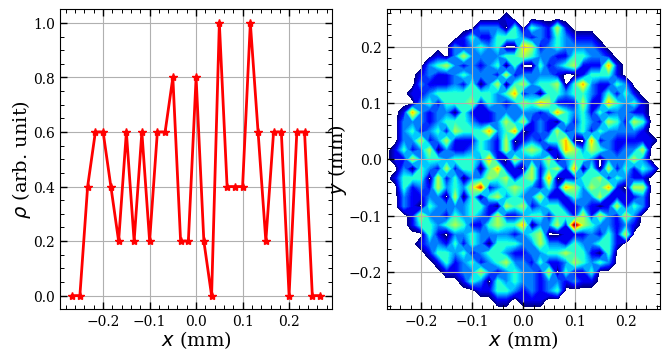

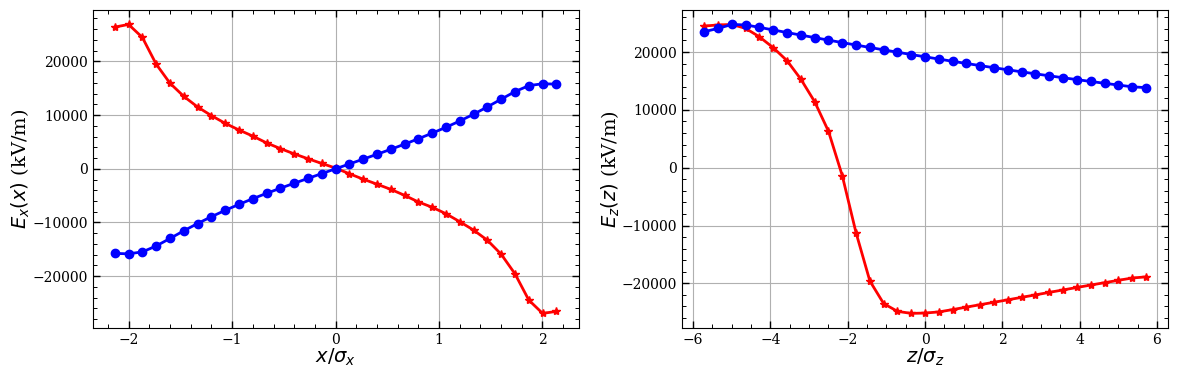

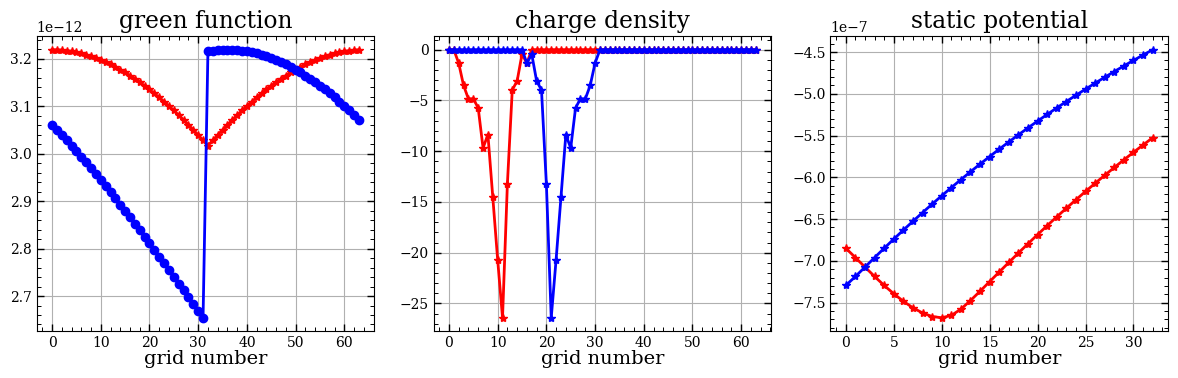

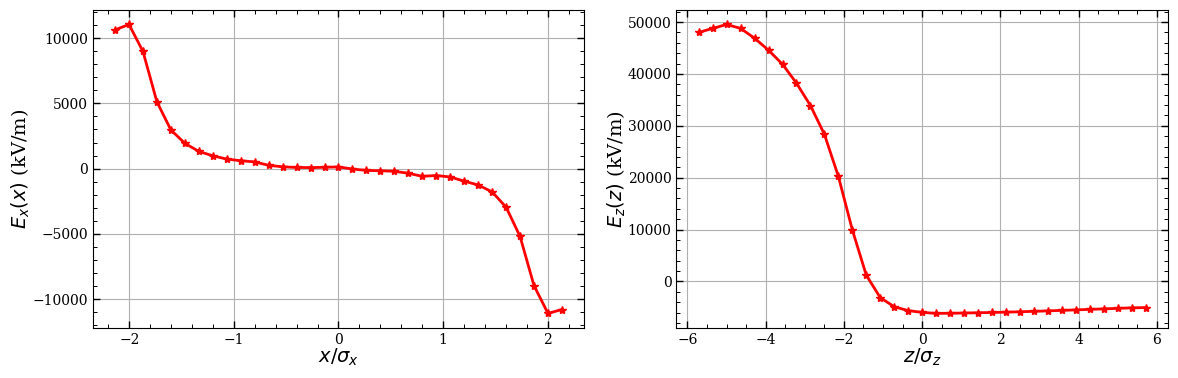

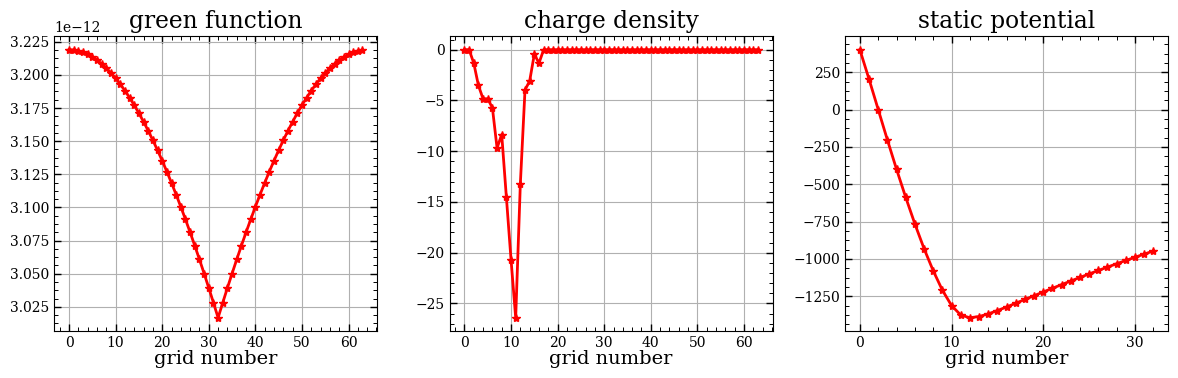

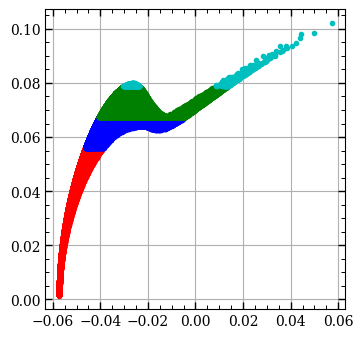

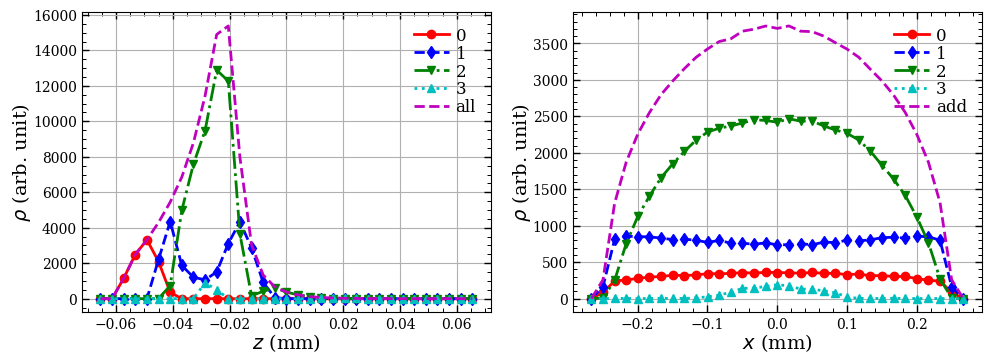

In [5]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge'
os.chdir(workdir)

#dist = np.loadtxt('ast.0528.999')
dist = np.loadtxt('trk.002000.001')

dist[1:,2] += dist[0,2] 
dist[1:,5] += dist[0,5]

Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz = 32, 32, 32
Nc = 5
gamma0 = 1. #+150./g_mec2; print gamma

xf, yf, zf = 0*sigma_x, 0, 0*sigma_x

import timeit
sc3d = SpaceCharge3DFFT(Nx, Ny, Nz, Nc, debug = 1, Lmirror = True)
time1 = timeit.default_timer()
#c3d.get_rho_3D1()
sc3d.get_rho_3D(dist = dist, Lemit = True)
sc3d.build(Xshift = (xf, yf, zf))
time2 = timeit.default_timer()
print 'time elapsed', time2-time1

sc3d4b = SpaceCharge3DFFT(Nx, Ny, Nz, Nc, debug = 1, Lmirror = True)
time1 = timeit.default_timer()
sc3d4b.get_rho_3D_binned(dist = dist, Lemit = True)
sc3d4b.build_binned(Xshift = (xf, yf, zf))
time2 = timeit.default_timer()
print 'time elapsed', time2-time1

In [ ]:
def demo(sc3d):
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z

    z0 = sc3d.zmean; print z0
    #z0 = 0;
    xx = np.linspace(-Nc*sigma_x, Nc*sigma_x, 2*Nx+1)+xf; #print xx
    yy = np.linspace(-Nc*sigma_y, Nc*sigma_y, 2*Ny+1); #print yy
    zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, 2*Nz+1)+z0; #print zz
    #zz = sc3d.zgrid_static#/sc3d.gamma0[0]
    
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+0*sigma_z)[0] for x in xx])/1e3, '-*')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0-1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0-2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    #ax.set_yticks(np.linspace(-200, 200, 11))
    ax.grid()
    ax.set_xlabel(r'$x/\sigma_x$')
    ax.set_ylabel(r'$E_x(x)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ex-x-z4.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 0*sigma_z)[1] for y in yy])/1e3, '-*')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$y/\sigma_y$')
    ax.set_ylabel(r'$E_y(y)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ey-y-z4.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(zz*1e3, np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])/1e3, '-')
    ax.plot(zz*1e3, np.array([sc3d.EM3D(sigma_x*0.375, 0, z)[2] for z in zz])/1e3, '-')
    ax.plot(zz*1e3, np.array([sc3d.EM3D(sigma_x*0.750, 0, z)[2] for z in zz])/1e3, '-')
    ax.plot(zz*1e3, np.array([sc3d.EM3D(sigma_x*1.125, 0, z)[2] for z in zz])/1e3, '-')
    ax.plot(zz*1e3, np.array([sc3d.EM3D(sigma_x*1.500, 0, z)[2] for z in zz])/1e3, '-')
    #ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$E_z(z)$ (kV/m)')
    ax.legend([r'$r/\sigma_x = 0$', r'$r/\sigma_x = 0.375$', r'$r/\sigma_x = 0.750$',\
               r'$r/\sigma_x = 1.125$', r'$r/\sigma_x = 1.500$'])
    fig.savefig('Ez-z-x4.eps')
    return
#sc3d.EM3D(0, 0, 0)
demo(sc3d)

0.0001250032987968215 0.00012500153419229486 1.2161076827898189e-05
5.78925e-05


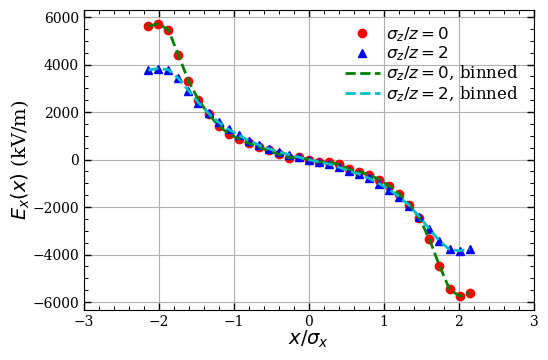

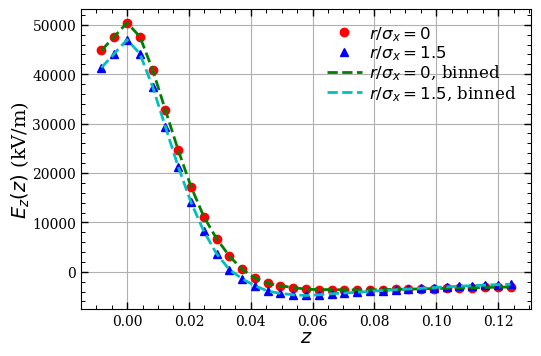

In [349]:
def demo():
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z
    
    z0 = sc3d.zmean; print z0
    
    xx = sc3d.xgrid
    yy = sc3d.ygrid
    zz = sc3d.zgrid+z0
    
    Nc = 3
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+0*sigma_z)[0] for x in xx])/1e3, 'ro')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+2*sigma_z)[0] for x in xx])/1e3, 'b^')
    
    z0 = sc3d4b.zmean
    xx = sc3d4b.xgrid
    ax.plot(xx/sigma_x,\
            np.array([sc3d4b.EM3D(x, 0, z0+0*sigma_z)[0] for x in xx])/1e3, 'g--')
    ax.plot(xx/sigma_x,\
            np.array([sc3d4b.EM3D(x, 0, z0+2*sigma_z)[0] for x in xx])/1e3, 'c--')
    
    
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    #ax.set_yticks(np.linspace(-200, 200, 11))
    ax.grid()
    ax.set_xlabel(r'$x/\sigma_x$')
    ax.set_ylabel(r'$E_x(x)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 2$',\
               r'$\sigma_z/z = 0$, binned', r'$\sigma_z/z = 2$, binned'])
    fig.savefig('Ex-x-z41.eps')
    
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(zz*1e3, np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])/1e3, 'ro')
    ax.plot(zz*1e3, np.array([sc3d.EM3D(sigma_x*1.5, 0, z)[2] for z in zz])/1e3, 'b^')
    
    zz = sc3d4b.zgrid+z0
    ax.plot(zz*1e3, np.array([sc3d4b.EM3D(0, 0, z)[2] for z in zz])/1e3, 'g--')
    ax.plot(zz*1e3, np.array([sc3d4b.EM3D(sigma_x*1.5, 0, z)[2] for z in zz])/1e3, 'c--')
    
    #ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$E_z(z)$ (kV/m)')
    ax.legend([r'$r/\sigma_x = 0$', r'$r/\sigma_x = 1.5$',\
               r'$r/\sigma_x = 0$, binned', r'$r/\sigma_x = 1.5$, binned'])
    fig.savefig('Ez-z-x41.eps')
    return
#sc3d.EM3D(0, 0, 0)
demo()

In [259]:
1e3*(sc3d.zgrid+sc3d.zmean)

array([-0.00827036, -0.00413518,  0.        ,  0.00413518,  0.00827036,
        0.01240554,  0.01654071,  0.02067589,  0.02481107,  0.02894625,
        0.03308143,  0.03721661,  0.04135179,  0.04548696,  0.04962214,
        0.05375732,  0.0578925 ,  0.06202768,  0.06616286,  0.07029804,
        0.07443321,  0.07856839,  0.08270357,  0.08683875,  0.09097393,
        0.09510911,  0.09924429,  0.10337946,  0.10751464,  0.11164982,
        0.115785  ,  0.11992018,  0.12405536])

0.001 0.001 0.001


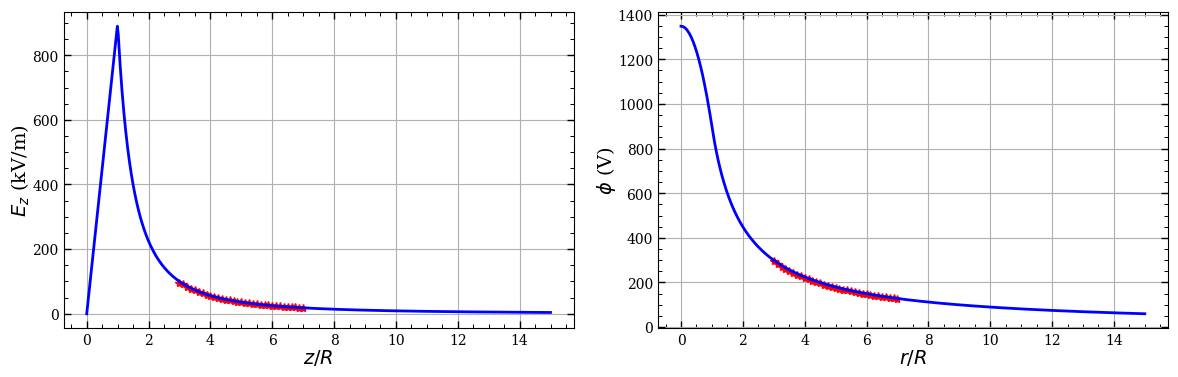

In [324]:
def demo2(sc3d):
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z
    
    zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, Nz+1); #print xx
    Ez = np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])
    
    data = np.loadtxt('R1mm.dat')
    
    fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
    ax1.plot((zz+zf)/sigma_z, Ez/1e3, '-*')
    ax1.plot(data[:,0]/sigma_z, data[:,2]/1e3, '-')
    #ax1.set_ylim(-200, 0)
    ax1.grid()
    ax1.set_xlabel(r'$z/R$')
    ax1.set_ylabel(r'$E_z$ (kV/m)')
    
    cc = -1./4/np.pi/g_eps0
    
    ax2.plot((zz+zf)/sigma_z, sc3d.PHI[Nx/2-1, Ny/2-1, :]*1./4/np.pi/g_eps0, '-*')
    ax2.plot(data[:,0]/sigma_z, data[:,1], '-')
    ax2.grid()
    #ax2.set_ylim(0, 500)
    ax2.set_xlabel(r'$r/R$')
    ax2.set_ylabel(r'$\phi$ (V)')
    
    plt.tight_layout()
    #fig.savefig('field-on-axis-from-uniform-ball2.eps')
    return
demo2(sc3d)

# Tracking

In [351]:
def build_cavity(filename, z0, amp, freq, phi0 = 0):
    #print phi_0
    data = np.loadtxt(filename)
    
    a, b = np.max(data[:,1]), np.min(data[:,1])
    Ez_z = data[:,1]/a*amp
    
    dz = data[1,0]-data[0,0]
    
    dEz_dz1 = np.gradient(   Ez_z, dz)
    dEz_dz2 = np.gradient(dEz_dz1, dz)
    dEz_dz3 = np.gradient(dEz_dz2, dz) 
    
    fEz_0 = interp1d(data[:,0],    Ez_z, bounds_error = False, fill_value = 0)
    fEz_1 = interp1d(data[:,0], dEz_dz1, bounds_error = False, fill_value = 0)
    fEz_2 = interp1d(data[:,0], dEz_dz2, bounds_error = False, fill_value = 0)
    fEz_3 = interp1d(data[:,0], dEz_dz3, bounds_error = False, fill_value = 0)
    
    #dEz_dz = np.zeros((len(data[:,0]), 4))
    #dEz_dz[:,0] = data[:,0]
    #dEz_dz[:,1] = dEz_dz1
    #dEz_dz[:,2] = dEz_dz2
    #dEz_dz[:,3] = dEz_dz3
    #fEz_z = interp1d(dEz_dz[:,0], dEz_dz[:,1:4], bounds_error = False, fill_value = 0)
    
    def EM3D(x, y, z, t = 0):
        if np.isscalar(x):
            x = [x]
            y = [y]
            z = [z]
        x = np.asarray(x)
        y = np.asarray(y)
        z = np.asarray(z)
        if not np.isscalar(t):
            t = np.asarray(t)

        omega = 2.*np.pi*freq
        phi = (phi0+0)*np.pi/180

        ww = omega**2/g_c**2
        
        r = np.sqrt(x*x+y*y)
        
        z1 = z-z0
        Ez0 = fEz_0(z1); #print Ez0
        Ez1 = fEz_1(z1)
        Ez2 = fEz_2(z1)
        Ez3 = fEz_3(z1)
        
        Ez = (     Ez0-r**2/4. *(Ez2+ww*Ez0))*np.sin(omega*t+phi)
        Er = (-0.5*Ez1+r**2/16.*(Ez3+ww*Ez1))*np.sin(omega*t+phi) # Er/r instead of Er
        Bt = ( 0.5*Ez0-r**2/16.*(Ez2+ww*Ez0))*ww/omega*np.cos(omega*t+phi) # Bt/r instead of Bt
        
        Ez = np.where(z<0, 0, Ez)
        Er = np.where(z<0, 0, Er)
        Bt = np.where(z<0, 0, Bt)
        
        F2d = np.zeros((len(x), 6))
        F2d[:,0] = x*Er
        F2d[:,1] = y*Er
        F2d[:,2] = Ez
        F2d[:,3] =-y*Bt
        F2d[:,4] = x*Bt
        #F2d = [x*Er, y*Er, Ez, -y*Bt, x*Bt, 0*Bt]
        return F2d
    
    return EM3D
def build_solenoid(filename, z0, amp):
    
    data = np.loadtxt(filename)
    
    a, b = np.max(data[:,1]), np.min(data[:,1])
    Fz_z = data[:,1]/a*amp
    
    dz = data[1,0]-data[0,0]
    
    dFz_dz1 = np.gradient(Fz_z, dz)
    dFz_dz2 = np.gradient(dFz_dz1, dz)
    dFz_dz3 = np.gradient(dFz_dz2, dz)
    dFz_dz4 = np.gradient(dFz_dz3, dz)
    dFz_dz5 = np.gradient(dFz_dz4, dz)
    dFz_dz6 = np.gradient(dFz_dz5, dz)
    
    fFz_0 = interp1d(data[:,0], Fz_z,    bounds_error = False, fill_value = 0)
    fFz_1 = interp1d(data[:,0], dFz_dz1, bounds_error = False, fill_value = 0)
    fFz_2 = interp1d(data[:,0], dFz_dz2, bounds_error = False, fill_value = 0)
    fFz_3 = interp1d(data[:,0], dFz_dz3, bounds_error = False, fill_value = 0)
    fFz_4 = interp1d(data[:,0], dFz_dz4, bounds_error = False, fill_value = 0)
    fFz_5 = interp1d(data[:,0], dFz_dz5, bounds_error = False, fill_value = 0)
    fFz_6 = interp1d(data[:,0], dFz_dz6, bounds_error = False, fill_value = 0)
     
    def EM3D(x, y, z, t = 0):
        
        if np.isscalar(x):
            x = [x]
            y = [y]
            z = [z]
        x = np.asarray(x)
        y = np.asarray(y)
        z = np.asarray(z)
        
        if not np.isscalar(t):
            t = np.asarray(t)
        
        r = np.sqrt(x*x+y*y)
        
        z1 = z-z0
        Fz0 = fFz_0(z1)
        Fz1 = fFz_1(z1)
        Fz2 = fFz_2(z1)
        Fz3 = fFz_3(z1)
        Fz4 = fFz_4(z1)
        Fz5 = fFz_5(z1)
        Fz6 = fFz_6(z1)
        
        Bz = (Fz0-r*r/4.*Fz2+r**4/64.*Fz4-r**6/2034.*Fz6)
        Br = (-1/2.*Fz1+r**2/16.*Fz3-r**4/384.*Fz5) # Br/r instead of Br
        
        Bz = np.where(z<0, 0, Bz)
        Br = np.where(z<0, 0, Br)
        
        F2d = np.zeros((len(x), 6))
        F2d[:,3] = x*Br
        F2d[:,4] = y*Br
        F2d[:,5] = Bz
        #F2d = [0, 0, 0, x*Br, y*Br, Bz]
        return F2d
    return EM3D

class EMsolver():
    def __init__(self):
        self.em3d = {}
    def add_external_field(self, name, func):
        self.em3d.update({name:func})
    def get_field(self, x, y, z, t = 0):
        field = np.zeros((1, 6))
        for name, func in self.em3d.iteritems():
            field = np.add(field, func(x, y, z, t))
        return field

field_maps = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\field-maps'
gun3d = build_cavity(field_maps+os.sep+'gun42Cavity.txt', 0, 60, 1.3e9, 90)
sol3d = build_solenoid(field_maps+os.sep+'gunsolenoidsPITZ.txt', 0, 0.2)

em3d = EMsolver()
em3d.add_external_field('gun', gun3d)
em3d.add_external_field('solenoid', sol3d)

x, y, z = [0, 0, 0], [0, 0, 0.01], [0, 0.1, 0.1]
t = 0
#print gun3d(0, 0, 0), gun3d(0, 0, 0.1), gun3d(0, 0.01, 0.1)
%timeit gun3d(x, y, z, t)
a = em3d.get_field([0, 0, 0], [0, 0, 0.01], [0, 0.1, 0.1]); print a
Ex, Ey, Ez, Bx, By, Bz = a.T[:]
print Ex, Ey, Ez

10000 loops, best of 3: 100 µs per loop
[[ 0.00000000e+00  0.00000000e+00  6.00000000e+01  0.00000000e+00
   0.00000000e+00  7.54907327e-07]
 [ 0.00000000e+00  0.00000000e+00 -5.27004354e+01  0.00000000e+00
   0.00000000e+00  3.21267830e-02]
 [ 0.00000000e+00  2.13025157e+00 -5.26015588e+01  1.46500557e-24
  -2.39859082e-03  3.19647551e-02]]
[0. 0. 0.] [0.         0.         2.13025157] [ 60.         -52.70043541 -52.6015588 ]


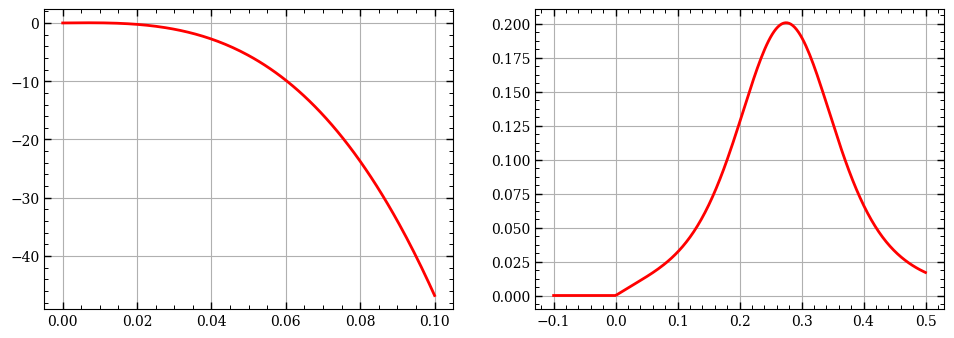

In [503]:
rr = np.linspace(0, 0.1, 200)
fr = np.array([em3d.get_field(v, 0, 0)[0,0] for v in rr])
zz = np.linspace(-0.1, 0.5, 200)
fz = np.array([em3d.get_field(0, 0.01, v, 0)[0,5] for v in zz])

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (12, 4))
ax1.plot(rr, fr, '-')
ax1.grid()

ax2.plot(zz, fz, '-')
ax2.grid()

In [552]:
a = np.array([[1, 2], [3, 4]])
b = np.copy(a)
b[0,0] = 0
print a,b

[[1 2]
 [3 4]] [[0 2]
 [3 4]]


In [553]:
class Beam():
    def __init__(self, fname = None, dist = None, debug = 0):
        self.diag = BeamDiagnostics(fname, dist)
        self.sc3d = SpaceCharge3DFFT(debug = debug)
        
        #self.key_value = {'x':0, 'ux':1, 'y':2, 'uy':3, 'z':4, 'uz':5, 'w':6}
        self.key_value = {'x':0, 'y':1, 'z':2, 'Px':3, 'Py':4, 'Pz':5, 'w':7}
        
        if fname is not None:
            self.dist = np.loadtxt(fname)
            self.dist[1:,2] += self.dist[0,2]
            self.dist[1:,5] += self.dist[0,5]
        elif dist is not None:
            self.dist = dist
        else:
            self.dist = []
        
        return
    def load(self, fname):
        self.diag = BeamDiagnostics(fname)
        self.dist = np.loadtxt(fname)
        
        # with open('beam.post.dat','a') as f_handle:
        #    np.savetxt(f_handle,np.atleast_2d(self.stat),fmt='%14.6E')
        return
    def get(self, i):
        return self.dist[i,:]
    def dump(self, fname):
        dist = np.copy(self.dist)
        dist[1:,2] -= dist[0,2]
        dist[1:,5] -= dist[0,5]
        np.savetxt(fname, dist, fmt = '%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%4.0f%4.0f')
        return
    def get_sc3d(self, Lmirror, Lemit):
        self.sc3d.get_rho_3D(dist = self.dist)
        self.sc3d.build()
        return self.sc3d.EM3D
    def diagnose(self):
        self.diag = BeamDiagnostics(dist = self.dist)
        return

In [560]:
def unwrap_step_i(arg, **kwarg):
    return Tracking.step_i(*arg, **kwarg)

class Tracking():
    def __init__(self, beam, em3d, t1, dt = 1e-12, t0 = 0, out_inteval = 100):
        self.beam = beam
        self.em3d = em3d
        
        self.clock = None
        self.time = t0
        self.dt = dt
        self.tend = t1
        self.stepped = 0
        self.out_inteval = out_inteval
        return
    
    def deriv0(self, t, y):
        '''
        Obsolete version, using beta*gamma as variables, here for reference
        Parameters
          t: time/s
          y[0]: x/m
          y[1]: bg_x
          y[2]: y/m
          y[3]: bg_x
          y[4]: z/m
          y[5]: bg_z
        Returns
          derivatives of those variables with respect to time
        '''
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0], y[2], y[4], t)

        bgx, bgy, bgz = y[1], y[3], y[5]
        gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)

        dydt = [0, 0, 0, 0, 0, 0]
        dydt[0] = y[1]*g_c/gamma
        dydt[1] = (bgy*Bz-bgz*By+Ex/g_c*gamma)/gamma/g_me*g_qe
        dydt[2] = y[3]*g_c/gamma
        dydt[3] = (bgz*Bx-bgx*Bz+Ey/g_c*gamma)/gamma/g_me*g_qe
        dydt[4] = y[5]*g_c/gamma
        dydt[5] = (bgx*By-bgy*Bx+Ez/g_c*gamma)/gamma/g_me*g_qe

        return dydt   
    def deriv1(self, t, y):
        '''
        Calculate derivatives of one particle
        Parameters
          t: time/s
          y[0]: x/m
          y[1]: y/m
          y[2]: z/m
          y[3]: P_x*c
          y[4]: P_y*c
          y[5]: P_z*c
        Returns
          derivatives of y with respect to t
        '''
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0], y[1], y[2], t)

        Pxc, Pyc, Pzc = y[3], y[4], y[5]
        g_mec2_eV = g_mec2*1e6
        gamma = np.sqrt(g_mec2_eV**2+Pxc**2+Pyc**2+Pzc**2)/g_mec2_eV

        dydt = [0, 0, 0, 0, 0, 0]
        dydt[0] = Pxc*g_c/gamma/g_mec2_eV
        dydt[1] = Pyc*g_c/gamma/g_mec2_eV
        dydt[2] = Pzc*g_c/gamma/g_mec2_eV
        dydt[3] = (Pyc*Bz-Pzc*By+g_mec2_eV*Ex/g_c*gamma)/gamma/g_me*g_qe
        dydt[4] = (Pzc*Bx-Pxc*Bz+g_mec2_eV*Ey/g_c*gamma)/gamma/g_me*g_qe
        dydt[5] = (Pxc*By-Pyc*Bx+g_mec2_eV*Ez/g_c*gamma)/gamma/g_me*g_qe

        return dydt   
    def deriv(self, t, y):
        '''
        Calculate derivatives of many particles altogeter
        Parameters
          t: time/s
          y[0]: x/m
          y[1]: y/m
          y[2]: z/m
          y[3]: P_x*c
          y[4]: P_y*c
          y[5]: P_z*c
        Returns
          derivatives of y with respect to t
        '''
        #import pdb; pdb.set_trace()
        #print inspect.stack()[0][3], len(y)
        y = np.reshape(y, (len(y)/6, 6))
        #if len(f_args)>0:
        #    size = size()
        #    clock = f_args[:,0]*1e-9
        #    charge = f_args[:,1]
        #    index = f_args[:,2]
        #    status = f_args[:,3]
        if self.clock is not None:
            clock = self.clock
        else:
            clock = np.zeros(len(y))
        
        #Ex, Ey, Ez, Bx, By, Bz = np.zeros((len(y), 6)).T[:]
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[:,0], y[:,1], y[:,2], t+clock).T[:]
        #Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0,0], y[0,1], y[0,2], t)[0]
        #import pdb; pdb.set_trace()
        
        Pxc, Pyc, Pzc = y[:,3], y[:,4], y[:,5]
        g_mec2_eV = g_mec2*1e6
        gamma = np.sqrt(g_mec2_eV**2+Pxc**2+Pyc**2+Pzc**2)/g_mec2_eV
        cc0 = g_c/gamma/g_mec2_eV
        cc1 = g_mec2_eV/g_c*gamma
        cc2 = 1./gamma/g_me*g_qe
        
        dydt = np.zeros((len(y), 6))
        dydt[:,0] = Pxc*cc0
        dydt[:,1] = Pyc*cc0
        dydt[:,2] = Pzc*cc0
        dydt[:,3] = (Pyc*Bz-Pzc*By+cc1*Ex)*cc2
        dydt[:,4] = (Pzc*Bx-Pxc*Bz+cc1*Ey)*cc2
        dydt[:,5] = (Pxc*By-Pyc*Bx+cc1*Ez)*cc2

        return dydt.flatten()
    
    def step_i(self, i):
        y0 = self.get(i)
        t0 = self.time

        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()
        r.integrate(r.t+self.dt)

        # self.set(i, r.y)
        return r.y 
    def step1(self, nstep = 1, num_cores=1):
        '''
        Integrate one particle by particle
        Return 
          (x, y, z, Px*c, Py*c, Pz*c)
        '''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        print nstep
        while nstep>0:
            self.stepped += 1

            if num_cores>1:
                # multi-core run
                # num = np.arange(self.NP)
                # results = Parallel(n_jobs=num_cores)(delayed(unwrap_step_i)(i) for i in zip([self]*len(num), num))
                # self.update(results)
                pass
            else:
                # run with one core
                r = ode(self.deriv1).set_integrator('dopri5')
                for i, Y in enumerate(self.beam.dist):
                    y0 = Y[0:6]
                    t0 = self.time
                    
                    r.set_initial_value(y0, t0).set_f_params()
                    r.integrate(r.t+self.dt)
                    #self.set(i, r.y)
                    self.beam.dist[i,0:6] = r.y

            self.time += self.dt
            nstep = nstep-1
            # self.update_sc()
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        print str.format('iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return    
    def step2(self, nstep = 1, num_cores=1):
        '''
        Integrate all particles together
        Returns
          (x, y, z, Px*c, Py*c, Pz*c)
        '''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        while nstep>0:
            self.stepped += 1
            
            if num_cores>1:
                # multi-core run
                # num = np.arange(self.NP)
                # results = Parallel(n_jobs=num_cores)(delayed(unwrap_step_i)(i) for i in zip([self]*len(num), num))
                # self.update(results)
                pass
            else:
                # run with one core
                nop = len(self.beam.dist[:,0:6])
                        
                y0 = self.beam.dist[:,0:6].flatten()
                r = ode(self.deriv).set_integrator('dopri5')
                t0 = self.time
                    
                r.set_initial_value(y0, t0).set_f_params()
                r.integrate(r.t+self.dt)
                #self.set(i, r.y)
                self.beam.dist[:,0:6] = np.reshape(r.y, (nop, 6))
            
            self.time += self.dt
            nstep = nstep-1
            # self.update_sc()
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        print str.format('iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return
    def step(self, nstep = 1, num_cores=1, NMAX = 10000):
        '''
        Integrate all particles together
        Returns
          (x, y, z, Px*c, Py*c, Pz*c)
        '''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        while nstep>0:
            self.stepped += 1
            
            dist = self.beam.dist
            select = (dist[:,9]>0)
            dist = dist[select]
            if num_cores>1:
                # multi-core run
                # num = np.arange(self.NP)
                # results = Parallel(n_jobs=num_cores)(delayed(unwrap_step_i)(i) for i in zip([self]*len(num), num))
                # self.update(results)
                pass
            else:
                # run with one core
                nop = len(dist)
                if nop>NMAX:
                    nbeamlet = int(1.0*(nop-1)/NMAX)+1
                    #print inspect.stack()[0][3], 'beamlets: ', nbeamlet
                    r = ode(self.deriv).set_integrator('dopri5')
                    for i in np.arange(nbeamlet):
                        #print inspect.stack()[0][3], 'beamlet: #', i
                        i0 = i*NMAX
                        i1 = i*NMAX+NMAX
                        if i1>nop:
                            i1 = nop
                        y0 = dist[i0:i1,0:6].flatten()
                        t0 = self.time
                        
                        r.set_initial_value(y0, t0).set_f_params()
                        r.integrate(r.t+self.dt)
                        
                        dist[i0:i1,0:6] = np.reshape(r.y, (i1-i0, 6))
                else:
                    r = ode(self.deriv).set_integrator('dopri5')
                    y0 = dist[:,0:6].flatten()
                    t0 = self.time

                    r.set_initial_value(y0, t0).set_f_params()
                    r.integrate(r.t+self.dt)
                    
                    dist[:,0:6] = np.reshape(r.y, (nop, 6))
            
            self.beam.dist[select] = dist
            
            self.time += self.dt
            nstep = nstep-1
            # self.update_sc()
            
            self.beam.diagnose()
            with open('trk.diag.001','a') as f_handle:
                np.savetxt(f_handle,np.atleast_2d(self.beam.diag.x), fmt='%14.6E')
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        if self.stepped % 10 == 0:
            print str.format('Tracking: iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return
    
    def is_emit(self):
        select = (self.beam.dist[:,9]==-1)|(self.beam.dist[:,9]==-3)
        if np.sum(select)>0:
            return True
        else:
            return False
    def emit(self, nstep = 1, num_cores=1, NMAX = 10000, NMIN = 30):
        '''
        Integrate all particles together
        Returns
          (x, y, z, Px*c, Py*c, Pz*c)
        '''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        while nstep>0:
            self.stepped += 1
            
            # Get the particles not emitted yet
            # dist = self.beam.dist
            select = (self.beam.dist[:,9]==-1)|(self.beam.dist[:,9]==-3)
            # Get also the particles emitted already
            select2 = (self.beam.dist[:,9]>0)
            dt_max = self.dt
            #import pdb; pdb.set_trace()

            # Select those to be emitted
            if np.sum(select)<=NMIN:
                sort = (self.beam.dist[select,6]).argsort()[::-1]; # print sort
                t1 = self.beam.dist[select][sort][0,6] # first particle to emit this time
                tc = self.beam.dist[select][sort][-1,6] # first particle to emit next time
                dt_max = (t1-tc)*1.05e-9
            else:
                sort = (self.beam.dist[select,6]).argsort()[::-1]; # print sort
                t1 = self.beam.dist[select][sort][0,6]
                tc = self.beam.dist[select][sort][NMIN,6]
                select *= (self.beam.dist[:,6]>tc)
                dt_max = (t1-tc)*1e-9
            dist_emit = self.beam.dist[select]
            
            # Particles emission one by one
            if 1:
                for i in np.arange(len(dist_emit)):
                    y0 = dist_emit[i,0:6]
                    dt = dt_max-(t1-dist_emit[i,6])*1e-9
                    t0 = self.time+dt_max-dt
                    r = ode(self.deriv).set_integrator('dopri5')

                    r.set_initial_value(y0, t0).set_f_params()
                    r.integrate(r.t+dt)

                    if not r.successful():
                        print inspect.stack()[0][3], 'Integration failed.'
                    
                    dist_emit[i,0:6] = r.y
                    if dist_emit[i,9] == -1:
                        dist_emit[i,9] = 5;
                    else:
                        dist_emit[i,9] *= -1
            else:
                # Shift backwards such that all particles start movement at the same time
                nop = len(dist_emit)
                shift_dt = (t1-dist_emit[:,6])*1e-9
                Pxc, Pyc, Pzc = dist_emit[:,3], dist_emit[:,4], dist_emit[:,5]
                g_mec2_eV = g_mec2*1e6
                gamma = np.sqrt(g_mec2_eV**2+Pxc**2+Pyc**2+Pzc**2)/g_mec2_eV
                cc0 = g_qe/(gamma*g_me*g_c)
                dist_emit[:,0] += -Pxc*cc0*shift_dt
                dist_emit[:,1] += -Pyc*cc0*shift_dt
                dist_emit[:,2] += -Pzc*cc0*shift_dt

                y0 = dist_emit[:,0:6].flatten()
                dt = dt_max
                t0 = self.time
                r = ode(self.deriv).set_integrator('dopri5')

                r.set_initial_value(y0, t0).set_f_params()
                r.integrate(r.t+dt)
                if not r.successful():
                    print inspect.stack()[0][3], 'Integration failed.'
                
                dist_emit[:,0:6] = np.reshape(r.y, (nop, 6))
                dist_emit[:,9] = np.where(dist_emit[:,9]==-1, 5, -dist_emit[:,9])                   
            
            # Replace the distributions with those
            self.beam.dist[select] = dist_emit
            
            # Now it's turn to advance one step for those emitted already
            dist = self.beam.dist[select2]
            
            if num_cores>1:
                # multi-core run
                pass
            else:
                # run with one core
                nop = len(dist); # print inspect.stack()[0][3], nop
                if nop == 0:
                    return
                if nop>NMAX:
                    nbeamlet = int(1.0*(nop-1)/NMAX)+1
                    #print inspect.stack()[0][3], 'beamlets: ', nbeamlet
                    r = ode(self.deriv).set_integrator('dopri5')
                    for i in np.arange(nbeamlet):
                        #print inspect.stack()[0][3], 'beamlet: #', i
                        i0 = i*NMAX
                        i1 = i*NMAX+NMAX
                        if i1>nop:
                            i1 = nop
                        y0 = dist[i0:i1,0:6].flatten()
                        t0 = self.time
                        r.set_initial_value(y0, t0).set_f_params()
                        r.integrate(r.t+dt_max)
                        
                        if not r.successful():
                            print inspect.stack()[0][3], 'Integration failed.'
                        
                        dist[i0:i1,0:6] = np.reshape(r.y, (i1-i0, 6))
                else:
                    r = ode(self.deriv).set_integrator('dopri5')
                    y0 = dist[:,0:6].flatten()
                    t0 = self.time
                    r.set_initial_value(y0, t0).set_f_params()
                    r.integrate(r.t+dt_max)
                    
                    if not r.successful():
                        print inspect.stack()[0][3], 'Integration failed.'
                    
                    dist[:,0:6] = np.reshape(r.y, (nop, 6))
            
            self.beam.dist[select2] = dist
            
            self.time += dt_max
            nstep = nstep-1
            # self.update_sc()
            
            self.beam.diagnose()
            with open('trk.diag.001','a') as f_handle:
                np.savetxt(f_handle,np.atleast_2d(self.beam.diag.x), fmt='%14.6E')
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        if self.stepped % 100 == 0:
            print str.format('Emitting: iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return
    
    def ref(self, y0, t1, dt, t0 = 0):
        '''
        Returns
          2D arraylike: (x, y, z, P_x*c, P_y*c, P_z*3, t)
        '''

        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()

        sol = [list(y0)+[t0]+list(self.em3d.get_field(y0[0], y0[1], y0[2], t0)[0])]
        while r.successful() and r.t<t1:
            r.integrate(r.t+self.dt)
            
            a = list(r.y)+[r.t]+list(self.em3d.get_field(r.y[0], r.y[1], r.y[2], r.t)[0])
            sol.append(a)
        
        sol = np.array(sol)
        np.savetxt('trk.ref.001', sol, fmt = '%12.6E')
        return sol  
    def auto_phase(self, freq = 1.3e9, t1 = 1000e-12, dt = 10e-12):
        '''
        Returns
          2D arraylike: (x, y, z, P_x*c, P_y*c, P_z*3, t)
        '''
        y0 = self.beam.dist[0]
        dist = np.array([y0 for i in np.arange(901)])
        #print inspect.stack()[0][3], dist.shape
        
        phase = np.linspace(0, 90, 901)
        self.clock = phase/360./freq
        #print self.clock*1e12
        
        t0 = 0
        y0 = dist[:,0:6].flatten(); #print inspect.stack()[0][3], len(y0)
        
        #import pdb; pdb.set_trace()
        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()
        
        r.integrate(r.t+dt)
        #import pdb; pdb.set_trace()
        #print inspect.stack()[0][3], r.successful()
        if not r.successful():
            print inspect.stack()[0][3], 'Integration failed.'
        
        while r.successful() and r.t < t1:
            #print inspect.stack()[0][3], r.t
            r.integrate(r.t+dt)
        #print inspect.stack()[0][3], r.t
        
        dist = np.reshape(r.y, (len(r.y)/6, 6))
        np.savetxt('auto.dat', dist, fmt = '%12.6E')
        
        i, m = index_max(dist[:,5])
        p0 = phase[i]
        #select = (phase>p0-10)*(phase<p0+10)
        
        #fun = lambda x, a, b, c, d, e: a+b*x+c*x**2+d*x**3+e*x**4
        #popt, pcov = sp.optimize.curve_fit(fun, phase[select], 1./dist[select,5])
        #res = sp.optimize.minimize(fun, p0, tuple(popt))
        
        fig, ax = plt.subplots(figsize = (6, 4))
        ax.plot(phase[:], dist[:,5]/1e6, '-')
        #ax.plot(phase[select], 1./fun(phase[select], *popt)/1e6, '-')
        ax.grid()
        ax.set_xlabel(r'phase (degree)')
        ax.set_ylabel(u_kinetic)
        fig.savefig('phase_scan.eps')
        
        #return [res.x[0], momentum2kinetic(1./fun(res.x[0], *popt)/1e6)]
        return [p0, momentum2kinetic(m/1e6)]

In [497]:
def emitting():
    dist = np.loadtxt('beam1.ini')
    NMIN = 20

    select = (dist[:,9]==-1)|(dist[:,9]==-3); print np.sum(select)
    #import pdb; pdb.set_trace()

    if np.sum(select)<=NMIN:
        dist_emit = dist[select]
        sort = (dist[select,6]).argsort()[::-1]; # print sort
        t0 = dist[select][sort][0,6]
        tc = dist[select][sort][-1,6];  print tc, (t0-tc)*1e3
    else:
        sort = (dist[select,6]).argsort()[::-1]; # print sort
        t0 = dist[select][sort][0,6]
        tc = dist[select][sort][NMIN,6]; print tc, (t0-tc)*1e3
        select *= (dist[:,6]>tc)
        dist_emit = dist[select]

    dist_emit[:,9] = 5
    dist[select] = dist_emit

    np.savetxt('beam2.ini', dist, fmt = '%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%12.4E%4.0f%4.0f')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.hist(dist[:,6], bins = 20, range = (-0.003, 0.003))
    select = (dist[:,9]==5)
    ax.hist(dist[select,6], bins = 20, range = (-0.003, 0.003), histtype = u'step')
    return
#emitting()
a = np.array([-1, -3, -3, -1])
a = np.where(a==-1, 5, -a)
print a

[5 3 3 5]


In [561]:
workdir = r"\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge"
os.chdir(workdir)

field_maps = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\field-maps'
gun3d = build_cavity(field_maps+os.sep+'gun42Cavity.txt', 0, 39.44e6, 1.3e9, 37)
sol3d = build_solenoid(field_maps+os.sep+'gunsolenoidsPITZ.txt', 0, -0.158797)

em3d = EMsolver()
em3d.add_external_field('gun', gun3d)
em3d.add_external_field('solenoid', sol3d)

#beam = Beam('beam.ini')
#sc3d = beam.get_sc3d()

#em3d.add_external_field('spacecharge', sc3d)

In [563]:
import timeit

beam = Beam('beam1.ini'); # beam.dist=beam.dist[0:100000]
track = Tracking(beam, em3d, 1000e-12, 1e-12, out_inteval = 250)

n_steps = 2000
n_stepped = 0
stime = 0
while n_stepped<n_steps:
    time1 = timeit.default_timer()
    
    if track.is_emit():
        flag = 'Emitting'
        nstep = 1
        track.emit(nstep, NMIN = 100)
    else:
        flag = 'Tracking'
        nstep = 10
        track.step(nstep)
    
    time2 = timeit.default_timer()
    stime = stime+(time2-time1)

    n_stepped += nstep

    #print flag, ': 1 step takes: ', stime/n_stepped

print 'Total time:', stime

Emitting: iter =    100, time = 1.646100E-12
Emitting: iter =    200, time = 2.007100E-12
Emitting: iter =    300, time = 2.249800E-12
Emitting: iter =    400, time = 2.444970E-12
Emitting: iter =    500, time = 2.612770E-12
Emitting: iter =    600, time = 2.763260E-12
Emitting: iter =    700, time = 2.902530E-12
Emitting: iter =    800, time = 3.034640E-12
Emitting: iter =    900, time = 3.162340E-12
Emitting: iter =   1000, time = 3.288009E-12
Emitting: iter =   1100, time = 3.413620E-12
Emitting: iter =   1200, time = 3.541120E-12
Emitting: iter =   1300, time = 3.672800E-12
Emitting: iter =   1400, time = 3.811490E-12
Emitting: iter =   1500, time = 3.960960E-12
Emitting: iter =   1600, time = 4.127240E-12
Emitting: iter =   1700, time = 4.320200E-12
Emitting: iter =   1800, time = 4.557900E-12
Emitting: iter =   1900, time = 4.905500E-12
Emitting: iter =   2000, time = 5.988300E-12
Total time: 2048.9937139


4.364102562588112 6.165644493564599


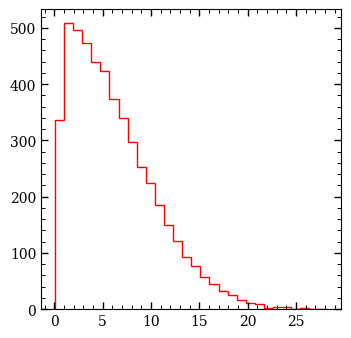

In [559]:
data = np.loadtxt('trk.000050.001')
data[1:,2] += data[0,2]; data[1:,5] += data[0,5]
select = (data[:,9]>0)
print np.std(data[select,5]/1e3), np.mean(data[select,5]/1e3)
r = plt.hist(data[select,5]/1e3, bins = 30, histtype = 'step')

In [473]:
beam = Beam('beam1.ini')
#beam.dist=beam.dist[0:100000]
track = Tracking(beam, em3d, 1000e-12, 1e-12)
#print track.beam.dist
import timeit
time1 = timeit.default_timer()
ref = track.step(1, NMAX = 3000)
#x = track.beam.dist[:,0]
#y = track.beam.dist[:,1]
#z = track.beam.dist[:,2]
#F2d = track.em3d.get_field(x, y, z, 0)
time2 = timeit.default_timer()
print time2-time1

iter =      1, time = 1.000000E-12
0.018521799997


In [167]:
print momentum2kinetic(7.4974E+02/1e6)
print kinetic2momentum(4.)

5.500106892036006e-07
4.481962914706011


0.998399099997
[37.0, 4.07778621086555]


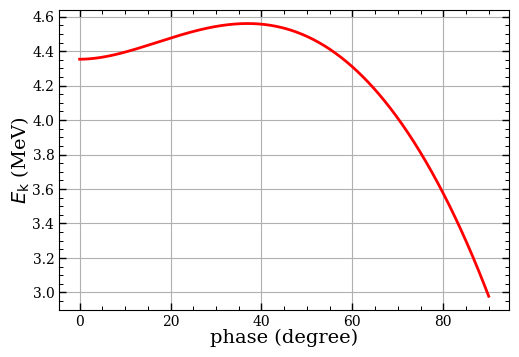

In [334]:
beam = Beam('beam.ini')
track = Tracking(beam, em3d, 1000e-12, 1e-12)

import timeit
time1 = timeit.default_timer()
phi = track.auto_phase()
time2 = timeit.default_timer()
print time2-time1
print phi

1.9814512
0


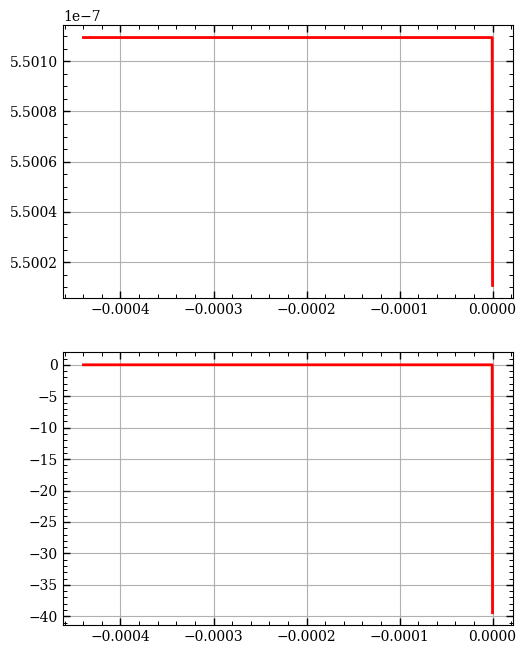

In [238]:
track = Tracking(beam, em3d, 1000e-12, 1e-12)
y0 = track.beam.dist[0,0:6]

import timeit
time1 = timeit.default_timer()
ref = track.ref(y0, 1000e-12, 10e-12)
time2 = timeit.default_timer()
print time2-time1
print track.time

fig, [ax1, ax2] = plt.subplots(figsize = (6, 8), nrows = 2)
Ek = momentum2kinetic(ref[:,5]/1e6); # print Ek[-1]
ax1.plot(ref[:,2], Ek, '-')
ax1.grid()

ax2.plot(ref[:,2], ref[:,9]/1e6, '-')
ax2.grid()

In [387]:
print momentum2kinetic(track.beam.dist[:,5]/1e6)

[4.07759511 4.07759511 4.07759511 ... 4.07723823 4.07734467 4.07745111]


## Tracker

In [9]:
I2B = lambda I: -(0.0000372+0.000588*I)
B2I = lambda B: (-B-0.0000372)/0.000588

beam = Beam('ast.0528.999')
dist = beam.dist

In [12]:
#%timeit d = BeamDiagnostics(dist = dist)
%timeit dist = np.loadtxt('ast.0528.999')

1 loop, best of 3: 2.18 s per loop


In [6]:
from tracker import *

workdir = r"\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge"
os.chdir(workdir)

field_maps = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\field-maps'
gun3d = build_cavity(field_maps+os.sep+'gun42Cavity.txt', 0, 39.44e6, 1.3e9, 36.94)
boo3d = build_cavity(field_maps+os.sep+'CDS14_15mm.txt', 2.675, 15.27e6, 1.3e9, 184.59)
sol3d = build_solenoid(field_maps+os.sep+'gunsolenoidsPITZ.txt', 0, -0.158797) # 270 A

em3d = EMsolver()
em3d.add_external_field('gun', gun3d)
#em3d.add_external_field('booster', boo3d)
em3d.add_external_field('solenoid', sol3d)
print em3d.get_field(0, 0, 0)

[[ 0.00000000e+00  0.00000000e+00  2.37025867e+07  0.00000000e+00
   0.00000000e+00 -5.99385094e-07]]


In [ ]:
import timeit

beam = Beam('beam1.ini'); # beam.dist=beam.dist[0:100000]
track = Tracking(beam, em3d, 1000e-12, 1e-12, dump_interval = 250, Lspch = True)

n_steps = 5000
n_stepped = 0
stime = 0
zmean = 0
while n_stepped<n_steps and zmean < 0.25:
    time1 = timeit.default_timer()
    
    if track.is_emit():
        flag = 'Emitting'
        nstep = 1
        kwargs = dict(Lemit = True, Lmirror = True)
        track.emit(nstep, NMIN = 100, **kwargs)
    else:
        flag = 'Tracking'
        nstep = 1
        kwargs = dict(Lemit = False, Lmirror = True)
        track.step(nstep, **kwargs)
    
    time2 = timeit.default_timer()
    stime = stime+(time2-time1)

    n_stepped += nstep

    if n_stepped % 100 == 0:
        print 'Current -> ', flag, ': on average 1 step takes: ', stime/n_stepped

print 'Total time:', stime

In [6]:
def test(**kwargs):
    for key, value in kwargs.items():
        print("{} is {}".format(key, value))

In [8]:
kwargs = dict(a = 1, b = 2)
test(**kwargs)

a is 1
b is 2
